# Crude Oil Price Analysis and Prediction Model

This notebook is used to carry out the ETL, EDA and Model experiments of the data downloaded from Alpha-Advantage API. The steps would be:

    1. Create a pipeline to download the dataset using the API
    2. Carry out and preliminary EDA on the data to determining the initial cleaning requirements.
    3. Add the cleaning steps to the pipeline.
    4. Carry out a full EDA on the data to determine additional transformations required and modelling technique(s) to explore.
    5. Split the data (if required for modelling technique)
    6. Create the model(s) and evaluate accordingly to select the best model(s)
    7. Save best model to utilise in the web app.
    8. This process will be repeated for each type of crude oil (West Texas Intermediate-WTI & Brent)

In [215]:
# Import the required libraries for ETL ,EDA and modelling

# Data wrangling and visusalisation libraries
import plotly.express as px
from datetime import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np

# Environment variables and file management libraries
from dotenv import load_dotenv
import os
import itertools

# API Library
from alpha_vantage.commodities import Commodities

# Statistical libraries
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from scipy.stats import boxcox



# Model Evaluation libraries
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Time Series Models
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from prophet import Prophet
from prophet.plot import plot_plotly

sns.set_theme()

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")


In [216]:
# Initialise the environment variable  and load the API_Key
load_dotenv(override=True)

# Load the API_KEY
api_key = os.getenv('api_key')

`We will create a pipeline that will extract, clean and save the data programmatically from the API. This would be built step by step below by adding components as the EDA is being done. The ETL code would be transfered to a Python Script.`

In [217]:
# # Create a data extraction Pipeline. This will be updated as the 
# class CommodityData:
#     """"
#     This class objects defines the data extraction, transformation, cleaning and loading stage of the application"""

#     def __init__(self, api_key=config.api_key):
#         """ Initiates the class object with the api_key.
#         Sets the base directory      
        
#         """
#         self.api_key=api_key
#         self.cd = Commodities(self.api_key)

#         base_dir = os.path.abspath(os.path.dirname(__file__))
#         self.data_dir = os.path.join(base_dir, 'data')


#     def etl_commodity_data(self, commodity, interval, start_date , end_date):
#         """" Extract data from alpha-vantage APi and save into csv if not already downloaded
        
#         Parameters:
#         commodity: The alpha-vantage commodity code 
#         interval: Interval for the data - options ['daily', 'monthly', 'yearly']
#         start_date: Start date for data in format YYYY-MM-DD 
#         end_date: End date for data in format YYYY-MM-DD   
#         """    

#         # Convert string dates to datetime objects 
#         start_date = datetime.strptime(start_date, '%Y-%m-%d') 
#         end_date = datetime.strptime(end_date, '%Y-%m-%d')
#         # today_date = datetime.strptime(str(datetime.now().strftime('%Y-%m-%d')), '%Y-%m-%d')
        
#         # from IPython import get_ipython # Get the current working directory 
#         # base_dir = get_ipython().run_line_magic('pwd', '')
#         # Get list of files in data directory
#         if commodity == 'WTI':
#             wti_dir = os.path.join(self.data_dir, 'WTI')
#             # Check if the directory exists and create it if it does not 
#             if not os.path.exists(wti_dir): 
#                 os.makedirs(wti_dir)
#             file = os.listdir(wti_dir)
            
#             # Check if there is no existing download
#             if str(end_date.strftime('%Y-%m-%d') + f'{interval}_.csv') not in file:
#                 # Download from API for commodity requested
#                 wti_data = self.cd.get_wti(interval)
                
#                 if wti_data[0].values.any() != "":
#                     wti_df = pd.DataFrame(wti_data[0])
                    
#                     # Transform to time-series df
#                     wti_df.set_index('date', drop=True, inplace=True)
                    
#                     # Convert date column to datetime
#                     wti_df.index = pd.to_datetime(wti_df.index)

#                     # Replace the . with nan
#                     wti_df['value'] = wti_df['value'].replace('.', np.nan)                         
                        
#                     # Fill missing data using backfill
#                     wti_df = wti_df.bfill()

#                     # Convert value column to float
#                     wti_df['value'] = wti_df['value'].astype('float')

#                     # Remove negative and zero values
#                     wti_df = wti_df[wti_df['value'] >= 0]

#                     # Load the full file to csv 
#                     wti_df.to_csv(f'data/{commodity}/{str(end_date.strftime('%Y-%m-%d') + f'{interval}_.csv')}')

#                     # Filter for the start date and end date
#                     wti_df = wti_df[(wti_df.index >= start_date) & (wti_df.index <= end_date)]
#                 else:
#                     data = pd.DataFrame() # Create an empty DataFrame if data is unavailable or response fails return
                    
#                     return print("No data available - try again later")
            
#                 return wti_df    
                    
#             else:
#                 wti_df = pd.read_csv(f'data/{commodity}/{str(end_date.strftime('%Y-%m-%d') + f'{interval}_.csv')}')
                
#                 # Transform to time-series df
#                 wti_df.set_index('date', drop=True, inplace=True)
                
#                 # Convert date column to datetime
#                 wti_df.index = pd.to_datetime(wti_df.index)
                                           
#                 # Replace the . with nan
#                 wti_df['value'] = wti_df['value'].replace('.', np.nan)        
#                 # Fill missing data using backfill
#                 wti_df = wti_df.bfill()

#                 # Convert value column to float
#                 wti_df['value'] = wti_df['value'].astype('float')

#                 # Remove negative and zero values
#                 wti_df = wti_df[wti_df['value'] >= 0]

#                 # Filter for the start date and end date
#                 wti_df = wti_df[(wti_df.index >= start_date) & (wti_df.index <= end_date)]
#             return wti_df
        
#         if commodity == 'brent':
#             brent_dir = os.path.join(self.data_dir, 'brent')
#             # Check if the directory exists and create it if it does not 
#             if not os.path.exists(brent_dir): 
#                 os.makedirs(brent_dir)
#             file = os.listdir(brent_dir)
            
#             # Check if there is no existing download
#             if str(end_date.strftime('%Y-%m-%d') + f'{interval}_.csv') not in file:
#                 # Download from API for commodity requested
#                 brent_data = self.cd.get_brent(interval)
                
#                 if brent_data[0].values.any() != "":
#                     brent_df = pd.DataFrame(brent_data[0])
                    
#                     # Transform to time-series df
#                     brent_df.set_index('date', drop=True, inplace=True)
                    
#                     # Convert date column to datetime
#                     brent_df.index = pd.to_datetime(brent_df.index)

#                     # Replace the . with nan
#                     brent_df['value'] = brent_df['value'].replace('.', np.nan)                         
                        
#                     # Fill missing data using backfill
#                     brent_df = brent_df.bfill()

#                     # Convert value column to float
#                     brent_df['value'] = brent_df['value'].astype('float')

#                     # Remove negative and zero values
#                     brent_df = brent_df[brent_df['value'] >= 0]

#                     # Load the full file to csv 
#                     brent_df.to_csv(f'data/{commodity}/{str(end_date.strftime('%Y-%m-%d') +'.csv')}')

#                     # Filter for the start date and end date
#                     brent_df = brent_df[(brent_df.index >= start_date) & (brent_df.index <= end_date)]
#                 else:
#                     data = pd.DataFrame() # Create an empty DataFrame if data is unavailable or response fails return
                    
#                     return print("No data available - try again later")
            
#                 return brent_df    
                    
#             else:
#                 brent_df = pd.read_csv(f'data/{commodity}/{str(end_date.strftime('%Y-%m-%d') + f'{interval}_.csv')}')
                
#                 # Transform to time-series df
#                 brent_df.set_index('date', drop=True, inplace=True)
              
#                 # Convert date column to datetime
#                 brent_df.index = pd.to_datetime(brent_df.index)
                                           
#                 # Replace the . with nan
#                 brent_df['value'] = brent_df['value'].replace('.', np.nan)        
#                 # Fill missing data using backfill
#                 brent_df = brent_df.bfill()

#                 # Convert value column to float
#                 brent_df['value'] = brent_df['value'].astype('float')
#                 # Filter for the start date and end date
#                 brent_df = brent_df[(brent_df.index >= start_date) & (brent_df.index <= end_date)]
#             return brent_df
        


In [218]:
# Instantiate the alpha_vantage API object
cd = Commodities(api_key)

## WEST TEXAS INTERMEDIATE (WTI)

### Data Loading and Exploration and Pre-Processing 

In [219]:
# Set variables for different scenarios
interval = ['daily', 'weekly', 'monthly']


In [220]:
# Download data from API
wti_data_daily = cd.get_wti(interval[0])
wti_data_weekly = cd.get_wti(interval[1])
wti_data_monthly = cd.get_wti(interval[2])

In [221]:
# Explore the type of data downloaded
type(wti_data_daily)

tuple

In [222]:
# Explore the content of the `tuple``
wti_data_daily

(             date  value
 0      2025-01-27  73.51
 1      2025-01-24  74.97
 2      2025-01-23  75.03
 3      2025-01-22  76.12
 4      2025-01-21  76.79
 ...           ...    ...
 10188  1986-01-08  25.87
 10189  1986-01-07  25.85
 10190  1986-01-06  26.53
 10191  1986-01-03  26.00
 10192  1986-01-02  25.56
 
 [10193 rows x 2 columns],
 None)

In [223]:
# Extract the DataFrames from the tuple
df_daily = wti_data_daily[0]
df_weekly = wti_data_weekly[0]
df_monthly = wti_data_monthly[0]

In [224]:
# Confirm the object extracted is a DataFrame
type(df_daily)

pandas.core.frame.DataFrame

In [225]:
# Explore the top of the dataset
df_daily.head(), df_weekly.head(), df_monthly.head()

(         date  value
 0  2025-01-27  73.51
 1  2025-01-24  74.97
 2  2025-01-23  75.03
 3  2025-01-22  76.12
 4  2025-01-21  76.79,
          date  value
 0  2025-01-24  75.73
 1  2025-01-17  79.28
 2  2025-01-10  75.14
 3  2025-01-03  73.15
 4  2024-12-27  70.51,
          date  value
 0  2024-12-01  70.12
 1  2024-11-01  69.95
 2  2024-10-01  71.99
 3  2024-09-01  70.24
 4  2024-08-01  76.68)

In [226]:
# Explore the tail of dataset
df_daily.tail(), df_weekly.tail(), df_monthly.tail()

(             date  value
 10188  1986-01-08  25.87
 10189  1986-01-07  25.85
 10190  1986-01-06  26.53
 10191  1986-01-03  26.00
 10192  1986-01-02  25.56,
             date  value
 2034  1986-01-31  19.69
 2035  1986-01-24  20.31
 2036  1986-01-17  24.57
 2037  1986-01-10  25.99
 2038  1986-01-03  25.78,
            date  value
 463  1986-05-01  15.38
 464  1986-04-01  12.84
 465  1986-03-01  12.61
 466  1986-02-01  15.46
 467  1986-01-01  22.93)

> We will use the daily data for our EDA.

In [227]:
df = df_daily.copy()

In [228]:
# Explore the general info of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10193 entries, 0 to 10192
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    10193 non-null  object
 1   value   10193 non-null  object
dtypes: object(2)
memory usage: 159.4+ KB


In [229]:
# Check for missing values
df.isna().sum()

date     0
value    0
dtype: int64

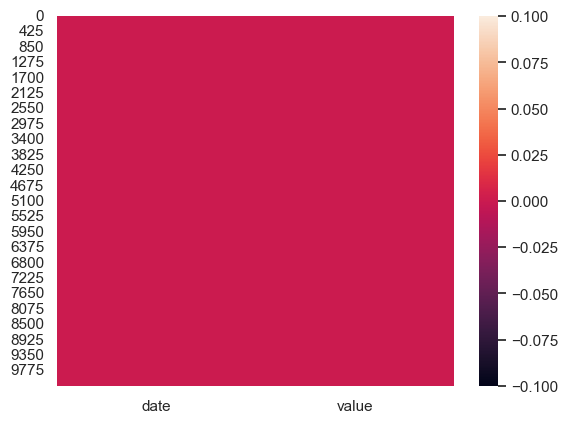

In [230]:
# Visualise for missing data
sns.heatmap(df.isnull());


We can see the following issues with the data quality with exploration done so far:

1. `date` and `value` columns have the `object` data type instead of `datetime` and `float` respectively.
2. The value has `.` as values thus not relecting as missing values

In [231]:
# Explore the instances of . as values further
len(df[df['value'] == '.'])

356

We will address these issues by:

1. Convert `date` column to datetime
2. Replace `.` values with `nan`
3. Impute missing values with backfill
4. Convert value data type to float

In [232]:
import numpy as np
# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])

# Replace . with nan
df['value'] = df['value'].replace('.', np.nan)

# Impute missing values with NaN
df.bfill(inplace=True)

# Convert value column to float
df['value'] = df['value'].astype('float')

# Confirm transformation and missing values
df.info(), df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10193 entries, 0 to 10192
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    10193 non-null  datetime64[ns]
 1   value   10193 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 159.4 KB


(None,
 date     0
 value    0
 dtype: int64)

In [233]:
# Explore the descriptive statistic summary
df.describe()

date         value
count                          10193  10193.000000
mean   2005-07-15 19:11:56.609437952     47.718316
min              1986-01-02 00:00:00    -36.980000
25%              1995-10-10 00:00:00     20.220000
50%              2005-07-15 00:00:00     40.630000
75%              2015-04-22 00:00:00     71.450000
max              2025-01-27 00:00:00    145.310000
std                              NaN     29.637114

There is a negative value which is not expected for commodity prices. This should be explored further. Let's see the distribution of prices.

<Figure size 800x500 with 0 Axes>

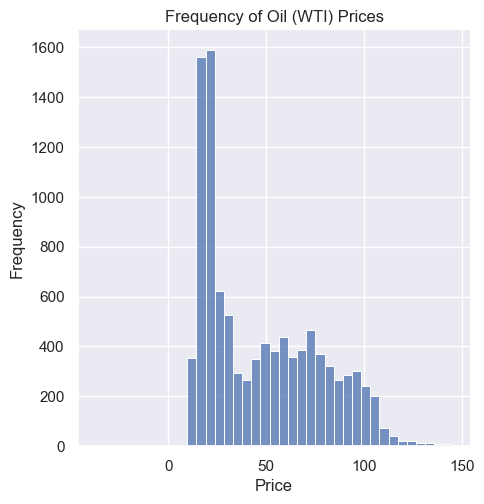

In [234]:
# Plot a histogram
plt.figure(figsize=(8,5))
sns.displot(data=df, x='value')
plt.title('Frequency of Oil (WTI) Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show();

The data is skewed to the right with a negative value which needs to be cleaned. There instances of high crude oil prices (`$120`- `$150`) but this is not very common

In [235]:
# Check for negative or zero values 
df[df['value'] <= 0]

date  value
1245 2020-04-20 -36.98

In [236]:
# Drop the negative value
df = df[df['value'] >= 0]

In [237]:
# Confirm the removal of negative or zero values 
df[df['value'] <= 0]

Empty DataFrame
Columns: [date, value]
Index: []

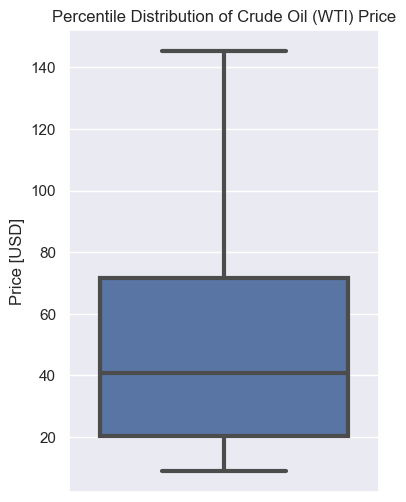

In [238]:
# Explore updated version of dataset with a boxplot
plt.figure(figsize=(4,6))
sns.boxplot(df['value'], linewidth=3)
plt.title('Percentile Distribution of Crude Oil (WTI) Price')
plt.ylabel('Price [USD]');

The 50% percentile i.e. median price is about `$40` while the highest price is about `~$145`. Lets run the descriptive statistics again to confirm the exact prices

In [239]:
df.describe()

date         value
count                          10192  10192.000000
mean   2005-07-15 06:30:05.651491456     47.726627
min              1986-01-02 00:00:00      8.910000
25%              1995-10-09 18:00:00     20.220000
50%              2005-07-14 12:00:00     40.660000
75%              2015-04-21 06:00:00     71.455000
max              2025-01-27 00:00:00    145.310000
std                              NaN     29.626689

In [240]:
# Convert the DataFrame to a timeseries
df.set_index('date', drop=True, inplace=True)


In [241]:
# Confirm we now have a time series dataset
df

value
date             
2025-01-27  73.51
2025-01-24  74.97
2025-01-23  75.03
2025-01-22  76.12
2025-01-21  76.79
...           ...
1986-01-08  25.87
1986-01-07  25.85
1986-01-06  26.53
1986-01-03  26.00
1986-01-02  25.56

[10192 rows x 1 columns]

In [242]:
# Create a helper function for the cleaning and transformation steps
def clean_transform_df(df):
    # Convert date column to datetime
    df['date'] = pd.to_datetime(df['date'])
    
    # Replace . with nan
    df['value'] = df['value'].replace('.', np.nan)
    
    # Impute missing values with NaN
    df.bfill(inplace=True)
    
    # Convert value column to float
    df['value'] = df['value'].astype('float') 

    # Drop the negative value
    df = df[df['value'] >= 0]
    
    # Convert the DataFrame to a timeseries
    df.set_index('date', drop=True, inplace=True)

    # Reduce the analysis horizon to 2020 and upwards
    df = df[df.index >= '2000']

    return df

In [243]:
df_weekly = clean_transform_df(df_weekly)
df_monthly = clean_transform_df(df_monthly)

### EDA of Time Series Dataset

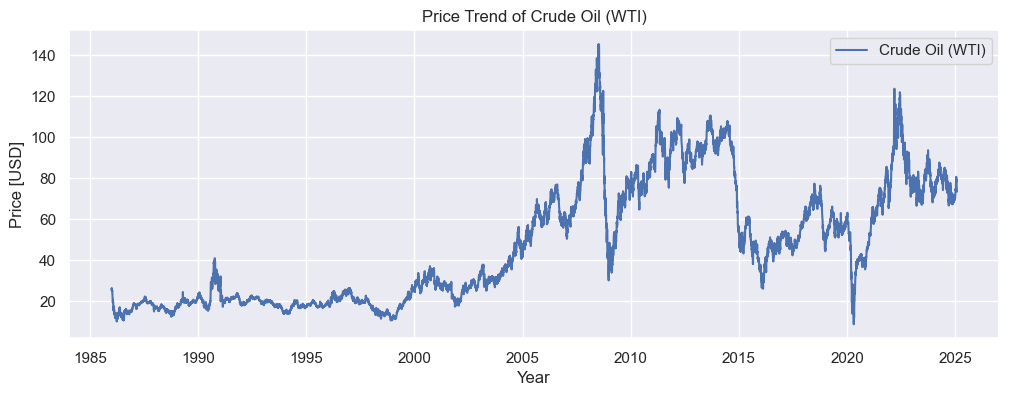

In [244]:
# Visualise the time series with a line plot
plt.figure(figsize=(12,4))
plt.plot(df, label='Crude Oil (WTI)')

plt.xlabel('Year')
plt.ylabel('Price [USD]')
plt.legend()
plt.title('Price Trend of Crude Oil (WTI)')
plt.show();


`The price was mostly with low volatilty until year 2000 from where the upward trend starts to become noticable. We can reduce our horizon from year 2000 - 2025. We will also add a monthly rolling average to smoothen the plot.`

In [245]:
# Reduce the analysis horizon to 2020 and upwards
df = df[df.index >= '2000']

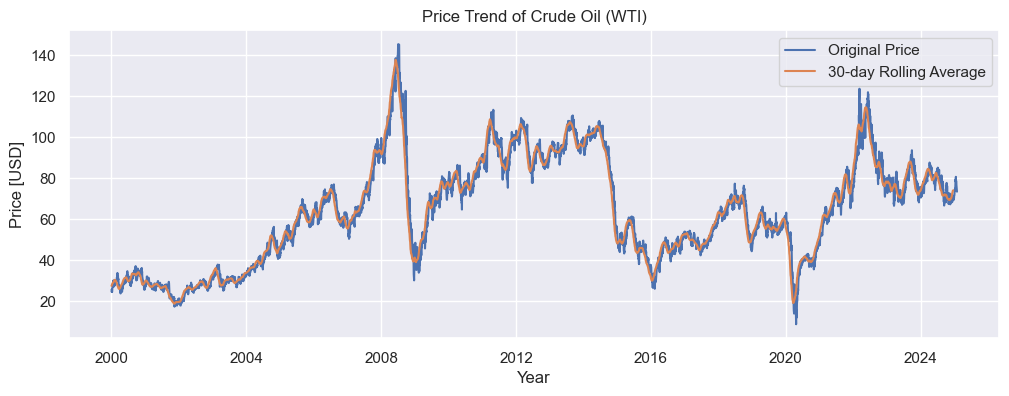

In [246]:
# Visualise the time series with a line plot from year 2000 with 
plt.figure(figsize=(12,4))
plt.plot(df, label='Original Price')
plt.plot(df.rolling(window=30).mean(), label='30-day Rolling Average')

plt.xlabel('Year')
plt.ylabel('Price [USD]')
plt.title('Price Trend of Crude Oil (WTI)')
plt.legend();

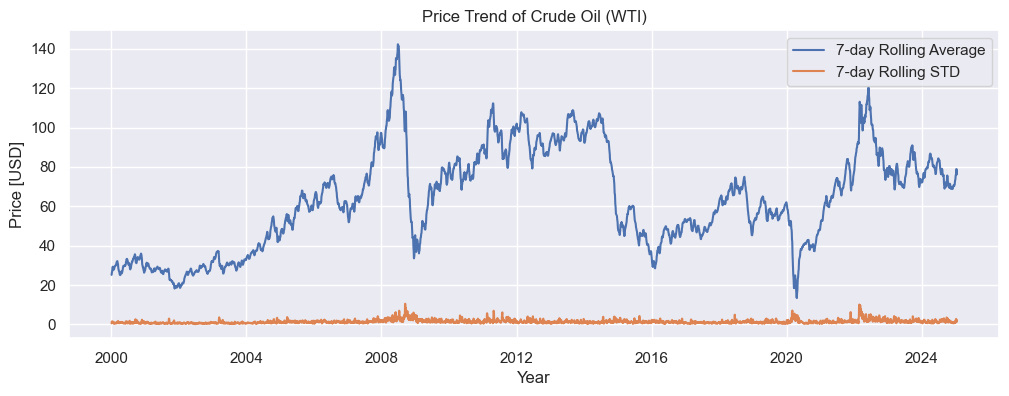

In [247]:
# let us explore a 7-day rolling average  and standard deviation as this should be more appropriate for a price change sensitive commodity like crude oil
plt.figure(figsize=(12,4))

plt.plot(df.rolling(window=7).mean(), label='7-day Rolling Average')
plt.plot(df.rolling(window=7).std(), label='7-day Rolling STD')
plt.xlabel('Year')
plt.ylabel('Price [USD]')
plt.title('Price Trend of Crude Oil (WTI)')
plt.legend();

`Visually inspecting the time series reveals a upward trend but we will need to go more granular to see seasonality visually. The data also do not look stationary. We will decompose to see the trend, seasonality and residuals, however lets plot the weekly and monthly data

In [248]:
# Create a function to plot different trend plats with rolling windows
def plot_ts(df, rolling=True, window=7, rolling_type='mean'):
    plt.figure(figsize=(12,3))
    plt.plot(df, label='Original Price')
    if rolling:
        if rolling_type == 'mean':
            plt.plot(df.rolling(window=window).mean(), label=f'{window}-day Rolling Average')
        else:
            plt.plot(df.rolling(window=window).std(), label=f'{window}-day Rolling STD')
 
    plt.xlabel('Year')
    plt.ylabel('Price [USD]')
    plt.title('Price Trend of Crude Oil (WTI)')
    plt.legend();
    

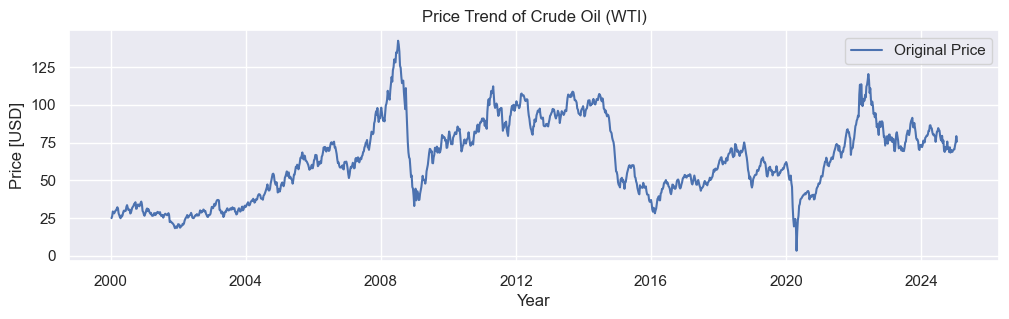

In [249]:
# Weekly data without rolling
plot_ts(df_weekly, rolling=False)

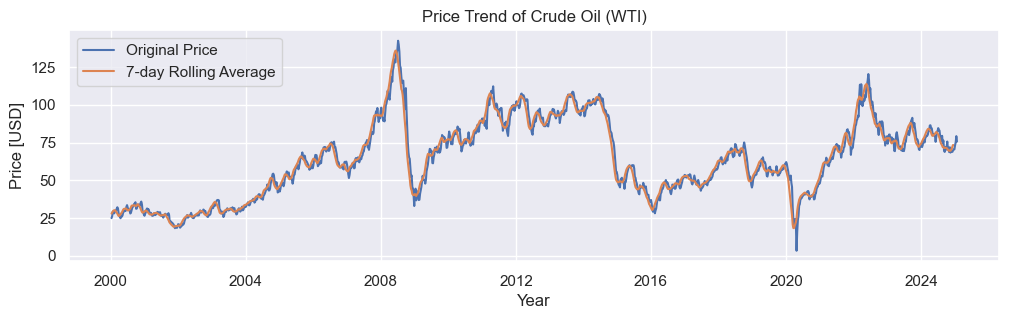

In [250]:
# Weekly data with 7 day rolling average 
plot_ts(df_weekly)

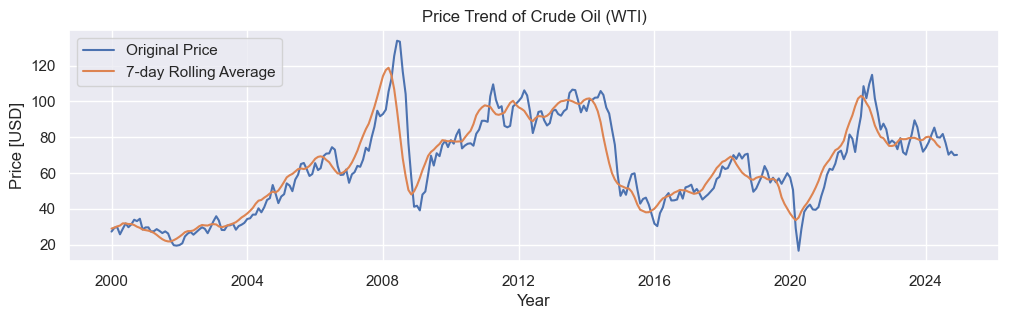

In [251]:
# Monthly data with 7-day rolling average
plot_ts(df_monthly, window=7)

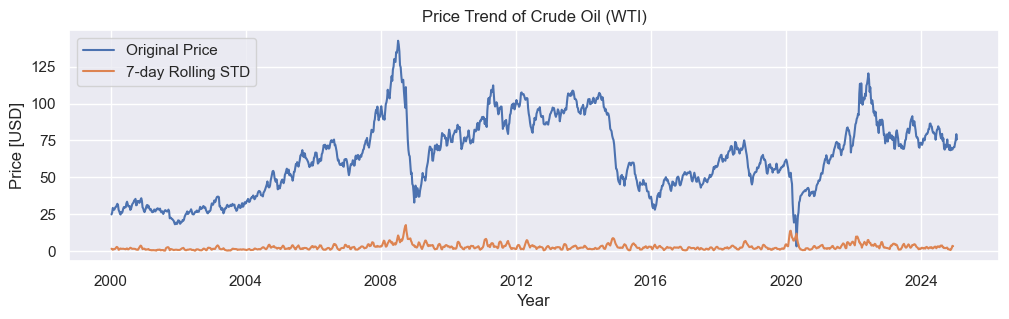

In [252]:
# Weekly data with 7-day rolling STD
plot_ts(df_weekly, rolling=True, rolling_type='std')

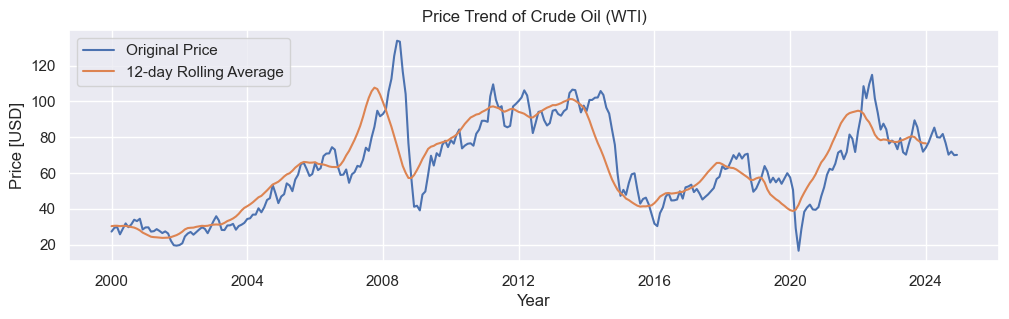

In [253]:
# Monthly data with 30-day rolling average 
plot_ts(df_monthly, window=12)

`Let us drill focus to see the yearly pattern for random years 2009 to 2022`

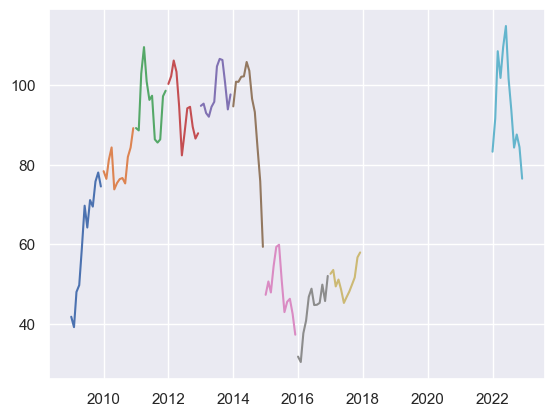

In [254]:
fig, ax = plt.subplots()
plt.plot(df_monthly.loc['2009'])
plt.plot(df_monthly.loc['2010'])
plt.plot(df_monthly.loc['2011'])
plt.plot(df_monthly.loc['2012'])
plt.plot(df_monthly.loc['2013'])
plt.plot(df_monthly.loc['2014'])
plt.plot(df_monthly.loc['2015'])
plt.plot(df_monthly.loc['2016'])
plt.plot(df_monthly.loc['2017'])
plt.plot(df_monthly.loc['2022'])

> We can see that the yearly trend are different however a subtle feel of price rises at middle months.

> We will next decompose to see the trend, seasonality and residuals

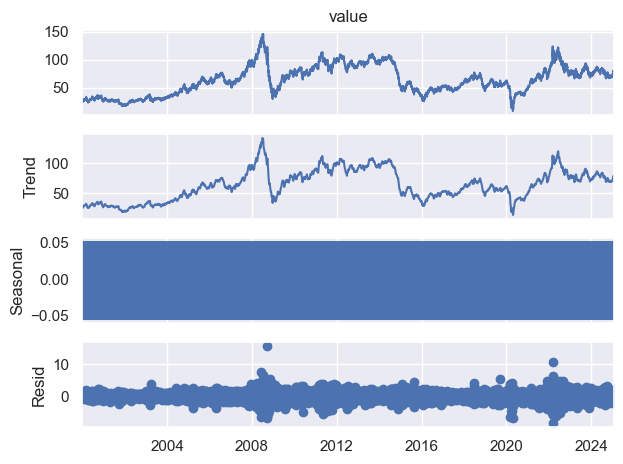

In [255]:
# Sort the time series dataset from oldest to latest date.
df = df.sort_index()

# Get the seasonal decomposition (additive) and plot
result = seasonal_decompose(df['value'] , model='add', period=7)
result.plot()
plt.show()

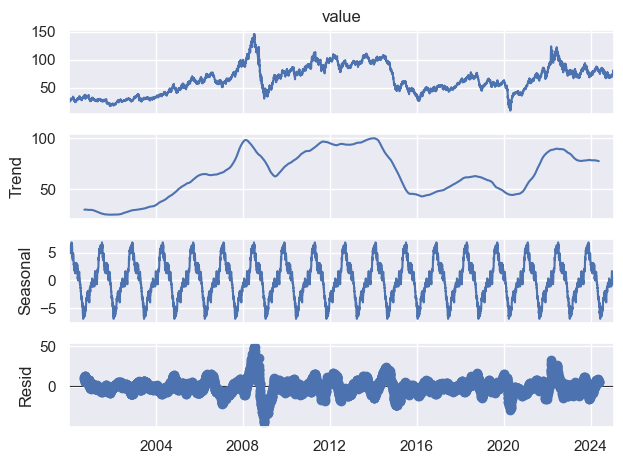

In [256]:
# Sort the time series dataset from oldest to latest date.
df = df.sort_index()

# Get the seasonal decomposition (additive) and plot
result = seasonal_decompose(df['value'] , model='add', period=365)
result.plot()
plt.show()

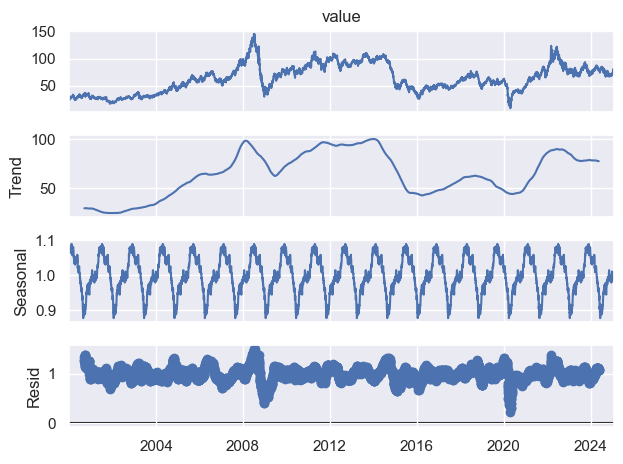

In [257]:
# Get the seasonal decomposition (multiplicative) and plot
result = seasonal_decompose(df['value'] , model='multiplicative', period=365)
result.plot()
plt.show()


`Original Data (value): This subplot shows the raw time series data over a period from around 2000 to 2025. There are clear fluctuations in the data with noticeable peaks and troughs, indicating variation over time. The significant spikes and dips noticeable are especially around 2008-2009 , 2015-2016 and 2020, indicating possible economic and external influences (e.g., financial crisis, supply glut (shale oil boom), covid pandemic)`

`Trend Component (Trend): This subplot isolates the underlying trend in the data. The trend component smooths out the short-term variations and highlights the long-term movement. From the plot, it looks like the trend follows a general upward trajectory over time with noticable sharp falls and gradual rise again.`

`Seasonal Component (Seasonal): This subplot shows the seasonal variations in the data, which are repetitive patterns that occur at regular intervals. Interestingly, there is a strong and regular seasonal pattern across the entire time series, indicating consistent cyclical behavior. `

`Residuals (Resid): This subplot depicts the residuals, which represent the noise or random fluctuations remaining after removing the trend and seasonal components. The residuals indicates that the noise is more or less evenly distributed over time except for the noticable time of peaks.Periods of higher residual variability, such as around 2009 ,2016 and 2020, suggest external shocks or anomalies in the data that are not captured by the trend or seasonal components. After 2020, residuals become slightly more stable, indicating a return to regular behavior.`

`To summarize, the original data shows significant variation over time, with an upward trend. There are notable seasonal patterns, and the residuals suggest that random noise is evenly spread throughout the data with noticable external influences`

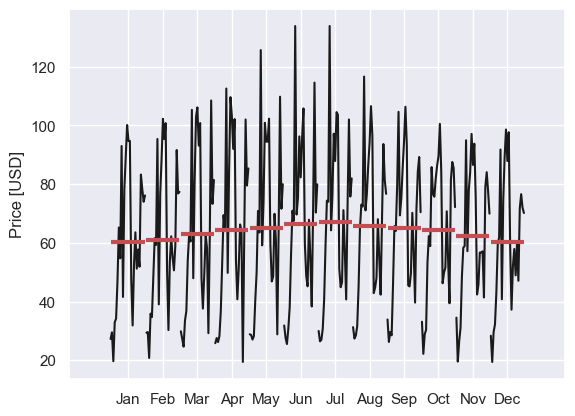

In [258]:
# let's us plot the monthly seasonality to confirm seasonality of the data
month_plot(df['value'].resample('ME').mean(), ylabel='Price [USD]')
plt.show();

`The crude oil price are usually higher around mid-year peaking in June. This can be related to people moving more around in summer than in the colder periods at the beginning and end of the year. However this seasonality is not very pronounced.`

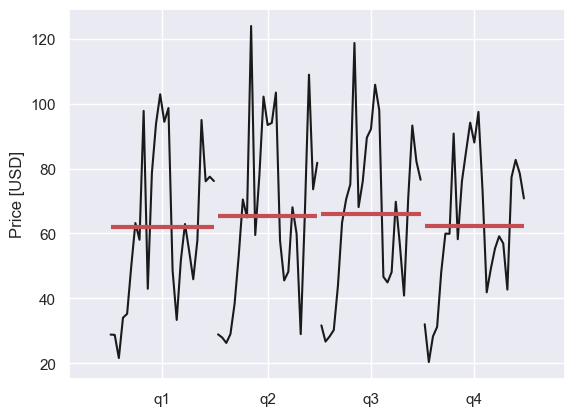

In [259]:
# let's us plot the quarterly seasonality to confirm seasonality of the data
quarter_plot(df['value'].resample('QE').mean(), ylabel='Price [USD]')
plt.show();

`So prices are usually slightly higher in the 2nd and 3rd quarter of the year`

In [260]:
# Check the dataset for stationality. Create a helper function for this
# From the plots, the data is not stationary visually. We will check with ADF 
def check_stationality(series):

    result = adfuller(series)
    if result[0] < result[4]['1%']:
        print("The time series is stationary")
    elif result[1] > 0.05:
        print("The time series is not stationary")
    print('')
    print('ADF Statistics:', result[0],)
    
    print('p-value:', result[1])
    print('Critical Values:', result[4])

In [261]:
# Check for stationality statistically
check_stationality(df)

The time series is not stationary

ADF Statistics: -2.646426919932534
p-value: 0.08377628958448674
Critical Values: {'1%': np.float64(-3.4313542798254937), '5%': np.float64(-2.861983805791875), '10%': np.float64(-2.5670062344527254)}


> We will need to make the time series stationary to be able to apply models like `ARIMA` and `SARIMAX`

> We will check autocolleration of the time series with past data points using both direct and indirect correlations- MA (ACF) and direct correllations -AR (PACF)`

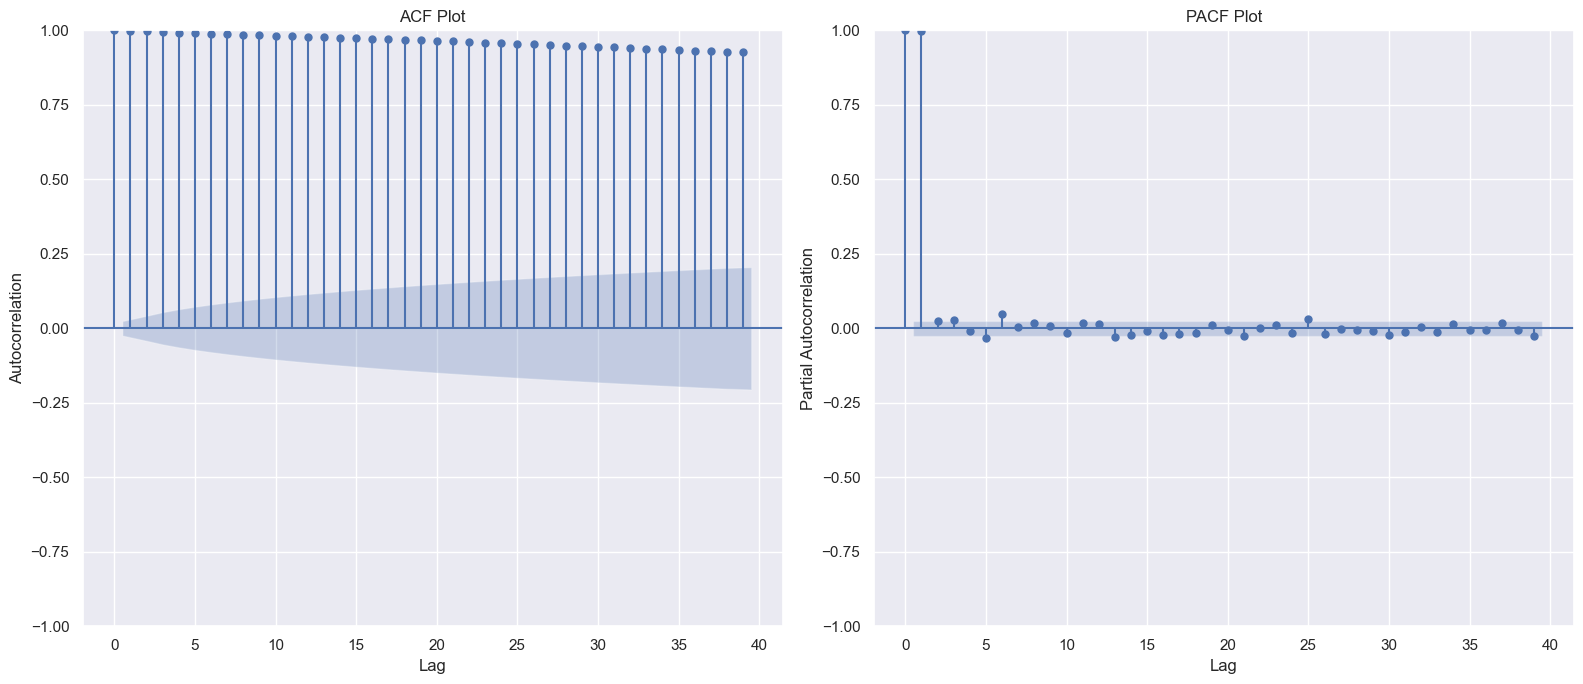

In [262]:
# Plot the acf 
# Create figure and axes 
fig, ax = plt.subplots(1, 2, figsize=(16, 7))

# Plot ACF 
plot_acf(df['value'], ax=ax[0]) 
ax[0].set_xlabel('Lag') 
ax[0].set_ylabel('Autocorrelation') 
ax[0].set_title('ACF Plot') 

# Plot PACF 
plot_pacf(df['value'], ax=ax[1]) 
ax[1].set_xlabel('Lag') 
ax[1].set_ylabel('Partial Autocorrelation') 
ax[1].set_title('PACF Plot') 

# Show plots 
plt.tight_layout() 
plt.show();


`The ACF showing slow decay suggests a correlation with longer lags which is sign of non-stationarity - this can be attributed to the strong trend as there is little seasonality in the data. Also the PACF show correlation drop off after lag=1. The mild seasonality every 6 months is evident in the PACF. We will do the differencing to take care of this non-stationarity and plot ACF and PACF again`

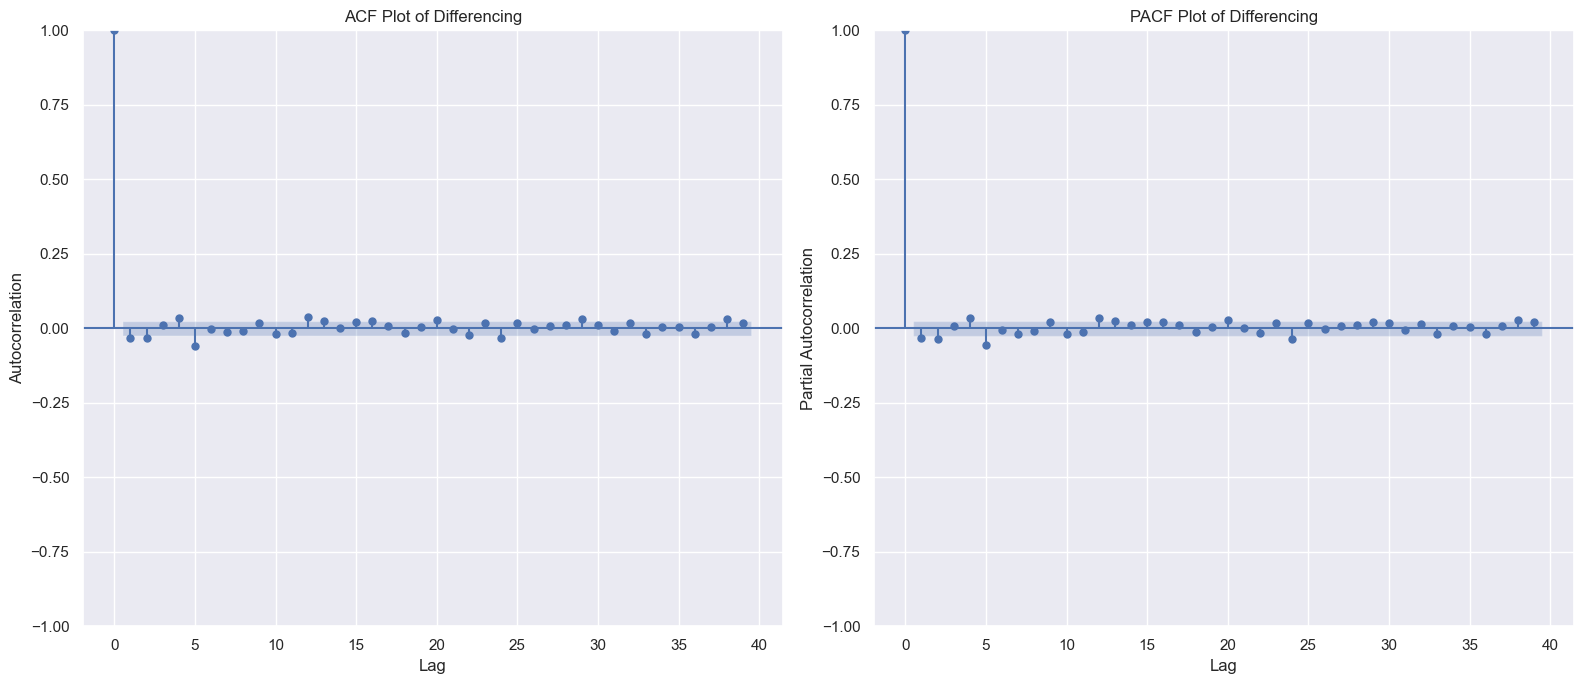

In [263]:
df['diff'] = df['value'].diff().dropna() 

fig, ax = plt.subplots(1, 2, figsize=(16, 7)) 

plot_acf(df['diff'].dropna(), ax=ax[0]) 
ax[0].set_xlabel('Lag') 
ax[0].set_ylabel('Autocorrelation') 
ax[0].set_title('ACF Plot of Differencing') 

plot_pacf(df['diff'].dropna(), ax=ax[1]) 

ax[1].set_xlabel('Lag') 
ax[1].set_ylabel('Partial Autocorrelation') 
ax[1].set_title('PACF Plot of Differencing') 

plt.tight_layout() 

plt.show();

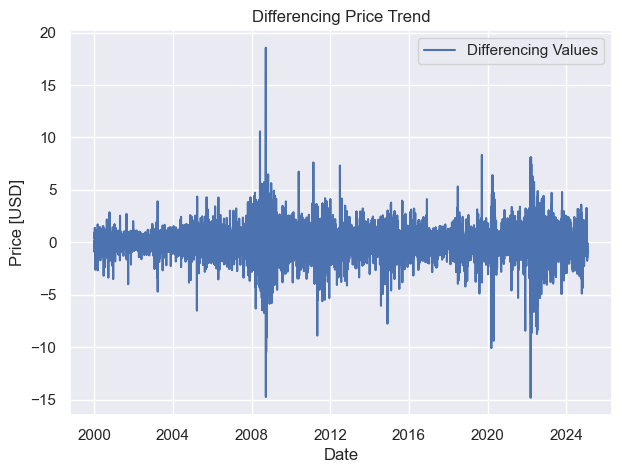

In [264]:
# Visualise the differencing to check if now stationary
plt.figure(figsize=(7,5))
plt.plot(df['diff'], label='Differencing Values')
plt.title("Differencing Price Trend")
plt.xlabel('Date')
plt.ylabel('Price [USD]')
plt.legend()
plt.show;

The time series differencing is stationary with notable spikes and dip that would be from external shokes that affected oil prices.

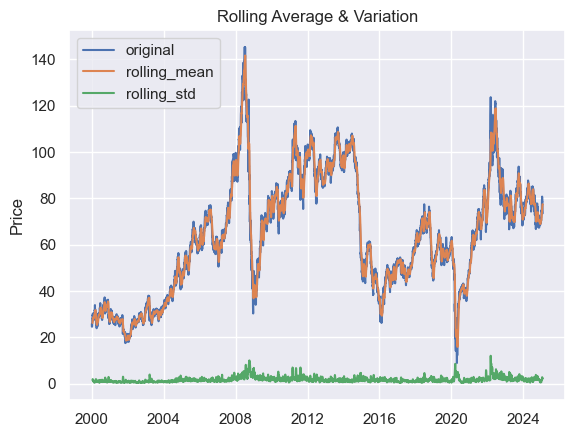

In [265]:
# Use rolling mean and std to further inspect for trends and seasonality
rolling_mean = df['value'].rolling(window=12).mean()
rolling_std = df['value'].rolling(window=12).std()
plt.plot(df['value'], label='original')
plt.plot(rolling_mean, label='rolling_mean')
plt.plot(rolling_std, label='rolling_std')
plt.title("Rolling Average & Variation")
plt.ylabel('Price')
plt.legend()
plt.show;

**EDA Summary**

> Based on the observed trends in the original data and the rolling mean, we can conclude that the time series is non-stationary in line with previous analysis as well. A stationary time series should have a constant mean and variance over time, which is not the case here. We have a non-constant mean showing a upward trend .There is a mild seasonal fluactuation in the price of crude oil (WTI). Spikes seen in 2008 and 2020 are easily explained from the global financial crisis of 2008, shale oil discovery in 2015/2016 and Covid-19 in 2020. The initial rise in 2022 can be ascribed to the Russia-Ukraine conflict with prices subsequently falling.

### Modelling

#### Exponential Smoothing - Holt-Winters

**Intro - Exponential Smoothing - Holt-Winters**

Exponential Smoothing - Holt-Winters is a powerful forecasting method used to model and predict time series data. 
It is particularly effective for data with seasonal patterns. The Holt-Winters method extends basic exponential smoothing by incorporating trends and seasonality components, making it suitable for various applications like sales forecasting, weather prediction, and inventory management.

The Holt-Winters method has three variations:
1. **Additive**: Suitable for time series with constant seasonal variations.
2. **Multiplicative**: Suitable for time series with seasonal variations that change proportionally with the level of the time series.
3. **Damped**: Suitable for time series with trends that gradually decrease over time.

The method uses three smoothing equations:
- **Simple** - ***Level***: Captures the overall level of the series. 
- **Double** - ***Trend***: Captures the trend (increasing or decreasing pattern) of the series.
- **Triple** - ***Seasonality***: Captures the repeating seasonal pattern.

By combining these components, the Holt-Winters method provides a comprehensive approach to time series forecasting, making it an essential tool for analysts and data scientists.


##### Simple Exponential Smoothing

> It does not catch trends and seasonality


In [266]:
# Check the top and bottom of the data as current is
df.head(), df.tail()

(            value  diff
 date                   
 2000-01-03  25.76   NaN
 2000-01-04  25.56 -0.20
 2000-01-05  24.65 -0.91
 2000-01-06  24.79  0.14
 2000-01-07  24.79  0.00,
             value  diff
 date                   
 2025-01-21  76.79 -1.77
 2025-01-22  76.12 -0.67
 2025-01-23  75.03 -1.09
 2025-01-24  74.97 -0.06
 2025-01-27  73.51 -1.46)

> We will create a training and test set. The target is to have a model that would forecast crude oil prices for the next quarter (90 days). However, this would be made a dynamic option as we work along.

In [267]:
# Set the test size which will be the forecast days as well.
def train_test_split(series, horizon=90):
    """
    Splits the time series data into train and test set
    input:
    df - Time Series dataset : pd.Series
    horizon - The number of days that will be forecasted. Same as test data size

    Return:
    Train and Test data set (pd.Series)
    
    """
    test_size = horizon

    train_df, test_df = series.iloc[:-test_size], series.iloc[-test_size:]
    print('The shape of the train set is:', train_df.shape)
    print('The shape of the test set is:', test_df.shape)
    return train_df, test_df

In [268]:
# Split the data for 90 days forecast and test as well
train_df, test_df = train_test_split(df['value'], 90)
assert len(test_df) == 90

The shape of the train set is: (6450,)
The shape of the test set is: (90,)


In [269]:
# Instantiate and fit a simple exponential smoothing model
model_simple = SimpleExpSmoothing(train_df).fit()

In [270]:
# Forecast using the model
predictions_simple = model_simple.forecast(len(test_df))
predictions_simple

6450    71.37494
6451    71.37494
6452    71.37494
6453    71.37494
6454    71.37494
          ...   
6535    71.37494
6536    71.37494
6537    71.37494
6538    71.37494
6539    71.37494
Length: 90, dtype: float64

> Simple exponental smoothing (SES) returns the same value for the forecast as expected. This is because SES assumes that the data follows a level (constant mean) pattern without any trend or seasonality. As more data is observed, the forecast stabilizes around a weighted average of past values. Once all past observations are incorporated, the forecast converges to a single steady value—the best estimate of the future based on past patterns.

***Key Intuition:***

> SES does not model trends or seasonality.
It assumes the best guess for the next value is the current smoothed level, which remains constant unless new observations significantly change it. The recent level, current level and alpha will all be the same in its formula. Thus, the repeated forecast values are not an error but a fundamental characteristic of SES

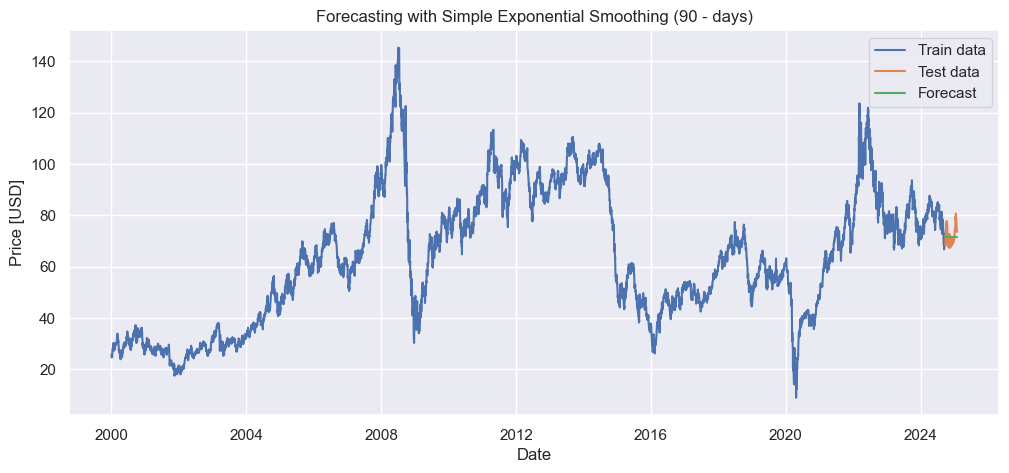

In [271]:
# Plot the train, test and forecast for visualization
plt.figure(figsize=(12,5))
plt.plot(train_df , label='Train data')
plt.plot(test_df, label='Test data')
plt.plot(test_df.index, predictions_simple, label='Forecast')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price [USD]')
plt.title('Forecasting with Simple Exponential Smoothing ' + f'({len(test_df)} - days)')


plt.show;

> Without any analysis we know the prediction is not good enough!!

##### Double Exponential Smoothing

> This adds another layer that handles trends in data - whether generally going up or down.
> 
> Does not handle seasonality!

In [272]:
# Instantiate and fit a double exponential smoothing (DES) model - multiplicative
model_double = ExponentialSmoothing(train_df, trend='mul').fit()

In [273]:
# Forecast using the model
predictions_double = model_double.forecast(len(test_df))
predictions_double

6450    71.406798
6451    71.424528
6452    71.442262
6453    71.460001
6454    71.477745
          ...    
6535    72.929693
6536    72.947801
6537    72.965914
6538    72.984031
6539    73.002153
Length: 90, dtype: float64

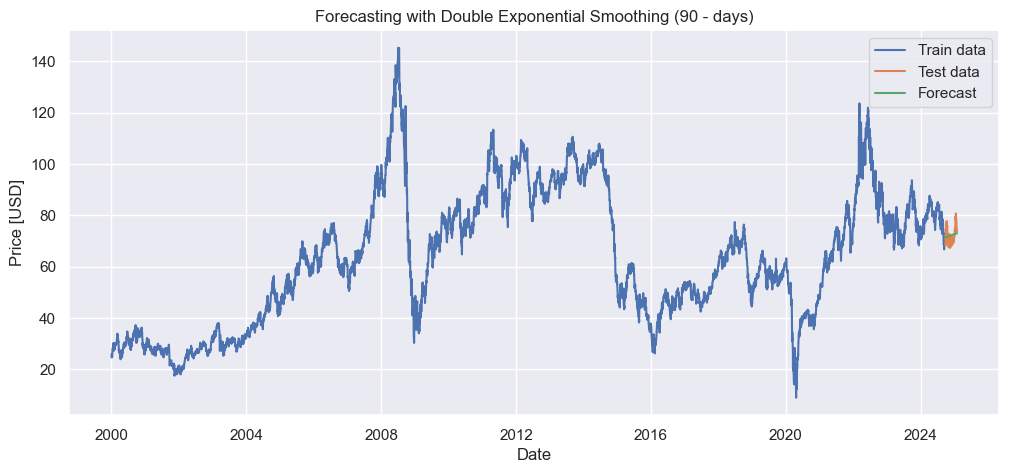

In [274]:
# Plot the train, test and forecast for visualization - DES -multiplicative
plt.figure(figsize=(12,5))
plt.plot(train_df , label='Train data')
plt.plot(test_df, label='Test data')
plt.plot(test_df.index, predictions_double, label='Forecast')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price [USD]')
plt.title('Forecasting with Double Exponential Smoothing ' + f'({len(test_df)} - days)')


plt.show;

> Let us use plotly express so we can zoom in more

In [275]:
# Plot the train, test and forecast for visualization using plotly express - DES -multiplicative
fig = px.line(train_df, x=train_df.loc['2005':].index,  y=train_df.loc['2005':], 
              title='Forecasting with Double Exponential Smoothing ' + f'({len(test_df)} - days)',
              labels={'value':"Train Data"},
              width=800,  
              height=500) 
fig.add_scatter(x=test_df.index, y=test_df, mode='lines', name='Test Data')
fig.add_scatter(x=test_df.index, y=predictions_double, mode='lines', name='Forecast')
fig.update_layout(xaxis_title='Date',
                 yaxis_title='Price [USD]')
fig.show()

> There is a slow upward trend predicted which is line with the test set trend even though the volatility is not captured by the forecast.

In [276]:
# Let's use the additive trend 
# Instantiate and fit a double exponential smoothing (DES) model - multiplicative
model_double = ExponentialSmoothing(train_df, trend='add').fit()

In [277]:
# Forecast using the model
predictions_double = model_double.forecast(len(test_df))

# Plot the train, test and forecast for visualization using plotly express - DES -multiplicative
fig = px.line(train_df, x=train_df.loc['2005':].index,  y=train_df.loc['2005':], 
              title='Forecasting with Double Exponential Smoothing ' + f'({len(test_df)} - days)',
              labels={'value':"Train Data"},
              width=800,  
              height=500) 
fig.add_scatter(x=test_df.index, y=test_df, mode='lines', name='Test Data')
fig.add_scatter(x=test_df.index, y=predictions_double, mode='lines', name='Forecast')
fig.update_layout(xaxis_title='Date',
                 yaxis_title='Price [USD]')
fig.show()


> The multiplcative trend is steeper as expected and can be considered better as its range (~+3) is closer to that of the test data (~+3) than that of the additive (~+1)

##### Triple Exponential Smoothing (Holt-Winters method)

> This adds another layer that handles seasonlaity in data

> It handles seasonality!

In [278]:
# Instantiate and fit a triple exponential smoothing (TES) model - multiplicative
model_triple = ExponentialSmoothing(train_df, trend='mul', 
                                    seasonal='add', 
                                    seasonal_periods=365).fit()

In [279]:
# Forecast using the model
predictions_triple = model_triple.forecast(len(test_df))

# Plot the train, test and forecast for visualization using plotly express - DES -multiplicative
fig = px.line(train_df, x=train_df.loc['2005':].index,  y=train_df.loc['2005':], 
              title='Forecasting with Triple Exponential Smoothing ' + f'({len(test_df)} - days)',
              labels={'value':"Train Data"},
              width=800,  
              height=500) 
fig.add_scatter(x=test_df.index, y=test_df, mode='lines', name='Test Data')
fig.add_scatter(x=test_df.index, y=predictions_triple, mode='lines', name='Forecast')
fig.update_layout(xaxis_title='Date',
                 yaxis_title='Price [USD]')
fig.show()

> From the EDA we had notice very negligible amount of seasonality in the data and this is being amplified by the TES which tries to model the seasonality and trend but not able to model this adequately looking at this visually. We would now calculate performance metrics to statistically quantify or evaluate the model performance

***Model Evaluation***

In [280]:
# Calculate the MAE, MSE, RMSE & MAPE
mae = mean_absolute_error(test_df, predictions_triple)
mse = mean_squared_error(test_df, predictions_triple)
rmse = root_mean_squared_error(test_df, predictions_triple)
mape = mean_absolute_percentage_error(test_df, predictions_triple)

print(f'The mean absolute error (MAE) is: {mae:.3f}')
print(f'The mean squared error (MSE) is: {mse:.3f}')
print(f'The root mean squared error (RMSE) is: {rmse:.3f}')
print(f'The mean absolute percentage error (MAPE) is: {mape * 100:.2f}%')

The mean absolute error (MAE) is: 2.879
The mean squared error (MSE) is: 13.346
The root mean squared error (RMSE) is: 3.653
The mean absolute percentage error (MAPE) is: 3.93%


> Next, we will combine all these into a function that would:
> 
* make predictions based on model selected
* horizon selected
* Calculate the evaluation metrics
* plot the train, test and forecast value

In [281]:
def train_evaluate_plot(series, horizon=90, 
                        exp_model_type='triple',
                       trend='mul', 
                        seasonal='add', seasonal_periods=365):
    """
    Trains an exponential smoothing model, evaluates and plots the forecast against the train and test data
    input:
    series - Time Series dataset : pd.Series
    horizon - The number of days that will be forecasted. Same as test data size
    exp_model_type - The type of exponential smoothing model to use. Options are 'simple', 'double' and 'triple'.
    trend - The type of trend to model. Options are 'additive', 'multiplicative', 'add' and 'mul'. 
    seasonal - The type of seasonality to model. Options are 'additive', 'multiplicative', 'add' and 'mul'. 
    seasonal_periods - The seasonality cycle period based on the data sample type (daily, weekly, monthly)

    Return:
    Evaluation metrics and plot of train, test and forecast
    
    """    
    
    
    # Split data into train and test
    train_df, test_df = train_test_split(series, horizon=horizon)

    
    
     # Build simple exponential smoothing and forecast
    if exp_model_type == 'simple':
        # Instantiate and fit SES
        model = SimpleExpSmoothing(train_df).fit()

        # Forecast with SES
        forecast = model.forecast(len(test_df))
    
    # Build double exponential smoothing and forecast
    elif exp_model_type == 'double':
        # Instantiate and fit DES
        model = ExponentialSmoothing(train_df, trend=trend).fit()
        
        # Forecast with DES
        forecast = model.forecast(len(test_df))

    # Build triple exponential smoothing and forecast
    else:
        model = ExponentialSmoothing(train_df, trend=trend, 
                                    seasonal=seasonal, 
                                    seasonal_periods=seasonal_periods).fit()
        
        # Forecast with TES
        forecast = model.forecast(len(test_df))
 
   
    # Evaluate and print metrics
    mae = mean_absolute_error(test_df, forecast)
    mse = mean_squared_error(test_df, forecast)
    rmse = root_mean_squared_error(test_df, forecast)
    mape = mean_absolute_percentage_error(test_df, forecast)
    
    print(f'The mean absolute error (MAE) is: {mae:.3f}')
    print(f'The mean squared error (MSE) is: {mse:.3f}')
    print(f'The root mean squared error (RMSE) is: {rmse:.3f}')
    print(f'The mean absolute percentage error (MAPE) is: {mape * 100:.2f}%')
    print(model.summary())

    # Plot forecast
    fig = px.line(train_df, x=train_df.loc['2005':].index,  y=train_df.loc['2005':], 
              title= f'Forecasting with {exp_model_type} Exponential Smoothing ' + f'({len(test_df)} - days)',
              labels={'value':"Train Data"},
              width=800,  
              height=500) 
    fig.add_scatter(x=test_df.index, y=test_df, mode='lines', name='Test Data')
    fig.add_scatter(x=test_df.index, y=forecast, mode='lines', name='Forecast')
    fig.update_layout(xaxis_title='Date',
                     yaxis_title='Price [USD]')
    fig.show()

    

    

In [282]:
train_evaluate_plot(df['value'], horizon=90, 
                        exp_model_type='triple',
                       trend='add', 
                        seasonal='mul', seasonal_periods=365)

The shape of the train set is: (6450,)
The shape of the test set is: (90,)
The mean absolute error (MAE) is: 3.262
The mean squared error (MSE) is: 15.243
The root mean squared error (RMSE) is: 3.904
The mean absolute percentage error (MAPE) is: 4.48%
                       ExponentialSmoothing Model Results                       
Dep. Variable:                    value   No. Observations:                 6450
Model:             ExponentialSmoothing   SSE                          14680.135
Optimized:                         True   AIC                           6042.577
Trend:                         Additive   BIC                           8541.385
Seasonal:                Multiplicative   AICC                          6087.991
Seasonal Periods:                   365   Date:                 Mon, 03 Feb 2025
Box-Cox:                          False   Time:                         15:59:09
Box-Cox Coeff.:                    None                                         
                   

> It is apparent that the Holt-Winters is not able to model the complexity of the crude oil price data as stated earlier. We would thus explore other models starting with ARIMA. With the non-seasonal variability (peaks and dips) from external events we expect ARIMA to also struggle with this data set.
> 
> One of the limitation of Holt-Winters is that it does not have room for regressors so external factors cannot be considered. Crude oil prediction is complex as it is affected by myriad of external factors such

> * Supply and Demand
> * Geopolitical Events e.g. Russia Ukraine conflict
> * Economic Indicators
> * Exchange Rates
> * Inventory Levels
> * Technological Advances e.g. shale oil production in the US.
> * Market Speculation etc.



#### ARIMA Model

`Based on the ACF & PACF, we would select an ARIMA model starting with (1, 1, 0). We will later carry out hyperparameter tuning for parameters (p, d, q) accordingly based on evaluations

In [283]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6540 entries, 2000-01-03 to 2025-01-27
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   6540 non-null   float64
 1   diff    6539 non-null   float64
dtypes: float64(2)
memory usage: 153.3 KB


In [284]:
# Fit ARIMA model on the data
model = ARIMA(df['value'], order=(1, 1, 0))
model_fit = model.fit()

# Print model summary
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                 6540
Model:                 ARIMA(1, 1, 0)   Log Likelihood              -12013.315
Date:                Mon, 03 Feb 2025   AIC                          24030.629
Time:                        15:59:11   BIC                          24044.200
Sample:                             0   HQIC                         24035.321
                               - 6540                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0310      0.006     -5.510      0.000      -0.042      -0.020
sigma2         2.3082      0.016    142.568      0.000       2.277       2.340
Ljung-Box (L1) (Q):                   0.01   Jarque-

**Diagnostic Tests Analysis**

| Test                       | Value     | Interpretation                                                                               |
|----------------------------|-----------|----------------------------------------------------------------------------------------------|
| Ljung-Box (L1) Q-test      | 0.01      | Tests if residuals are white noise (independent). The high p-value (0.93) suggests no autocorrelation in residuals. ✅ |
| Jarque-Bera (JB) Test      | 29889.98  | Tests normality of residuals. The p-value (0.00) suggests non-normal residuals ❌, meaning extreme values exist.         |
| Heteroskedasticity (H)     | 2.38      | Measures variance consistency. A high value (>1) suggests heteroskedasticity, meaning volatility changes over time. ❌ |
| Skewness                   | -0.31     | Slightly negative skew, meaning the distribution is slightly left-tailed.                        |
| Kurtosis                   | 13.46     | Very high (normal distribution = 3), meaning residuals have heavy tails (outliers exist). ❌   |


`The model is fitting well but there seems to be issues with the diagnostics indicate potential issues with residuals normality and heteroskedasticity, which might require adjustments or additional modeling techniques. The model has good p-values for AR. The external shocks to oil price are likely to be the culpriit here for the outlier values`

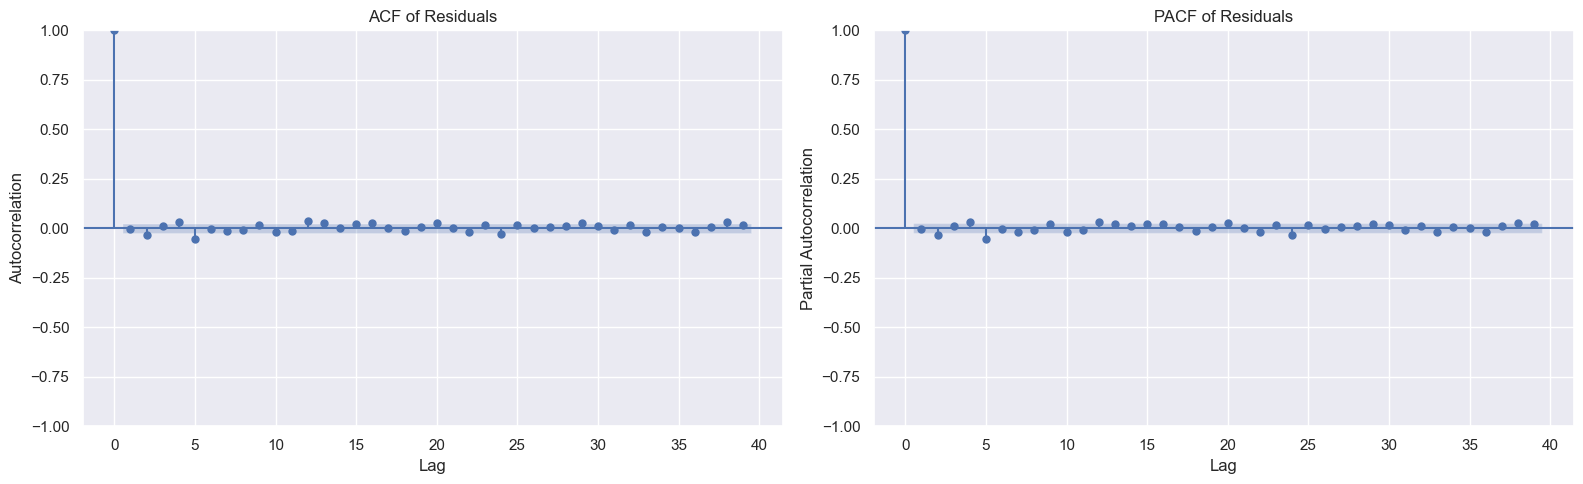

In [286]:
# Plot ACF and PACF of residuals 
residuals = model_fit.resid

fig, ax = plt.subplots(1, 2, figsize=(16, 5))

plot_acf(residuals, ax=ax[0])
ax[0].set_title('ACF of Residuals')
ax[0].set_xlabel('Lag')
ax[0].set_ylabel('Autocorrelation')

plot_pacf(residuals, ax=ax[1])
ax[1].set_title('PACF of Residuals')
ax[1].set_xlabel('Lag')
ax[1].set_ylabel('Partial Autocorrelation') 

plt.tight_layout()
plt.show()


This shows the model is fitting well with no autocorrelation in the residuals. After we will perform out-of-sample forecast to evaluate the model.

We will forecast for a 90 day period to evaluate

In [287]:
# Split the data into training and test datasets for out-of-sample forecast
test_days = 90

train_df , test_df = df.iloc[:-test_days], df.iloc[-test_days:]




In [288]:
len(train_df), len(test_df)

(6450, 90)

In [289]:
# Fit the model on the training dataset
model = ARIMA(train_df['value'], order=(1, 1, 0))
model_fit = model.fit()

In [290]:
# Forecast for the test set period
start = len(train_df) + 1
end = len(train_df) + len(test_df) 
forecast = model_fit.predict(start=start, end=end)

In [291]:
# Calculate evaluation metrics

mse = mean_squared_error(test_df['value'], forecast)
rmse = root_mean_squared_error(test_df['value'], forecast)

print('mean squared error:', mse)
print('root mean squared error:', rmse)

mean squared error: 10.044124714552892
root mean squared error: 3.1692467109003823


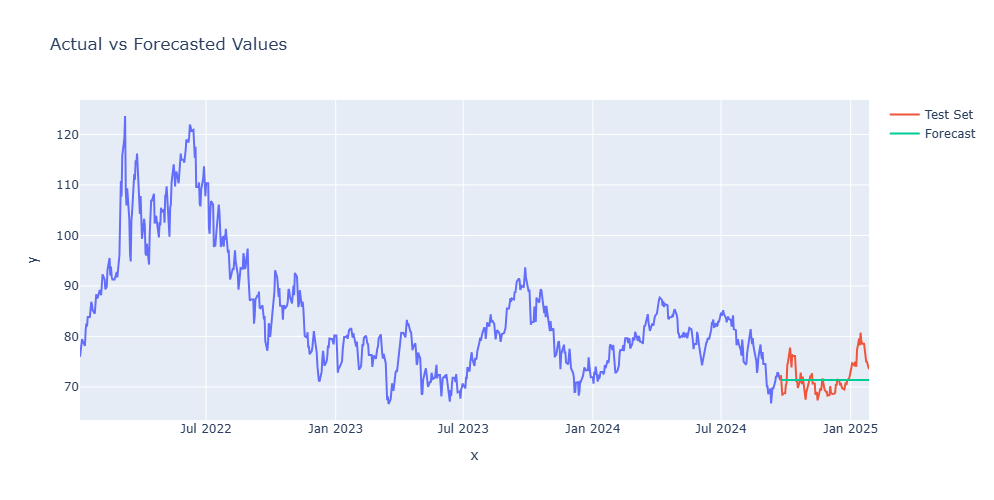

In [292]:
# Plot the actual vs forecasted values
fig = px.line(train_df, x=train_df.loc['2022':].index,  y=train_df.loc['2022':]['value'], 
              title='Actual vs Forecasted Values',
              labels={'value':"Price"},
              width=800,  
              height=500) 
fig.add_scatter(x=test_df.index, y=test_df['value'], mode='lines', name='Test Set')
fig.add_scatter(x=test_df.index, y=forecast, mode='lines', name='Forecast')

fig.show()


In [293]:
# Create a helper function for modelling and evaluation
def model_evaluate_plot(ts_data, horizon=180, order=(1, 1, 0), from_year='2022'):
    # Split the data into training and test datasets for out-of-sample forecast
    test_days = horizon

    train_df , test_df = ts_data.iloc[:-test_days], ts_data.iloc[-test_days:]
    # Fit the model on the training dataset
    model = ARIMA(train_df['value'], order=order)
    model_fit = model.fit()

    # Forecast for the test set period
    start = len(train_df) + 1
    end = len(train_df) + len(test_df) 
    forecast = model_fit.predict(start=start, end=end)
    
    # Calculate evaluation metrics
    mse = mean_squared_error(test_df['value'], forecast)
    rmse = root_mean_squared_error(test_df['value'], forecast)
    aic = model_fit.aic

    print('mean squared error:', mse)
    print('root mean squared error:', rmse)
    print('ARIMA{}- AIC:{}'.format(order, aic))
 

    # Plot the actual vs forecasted values
    fig = px.line(train_df, x=train_df.loc['2022':].index,  y=train_df.loc['2022':]['value'], 
                  title='Actual vs Forecasted Values',
                  labels={'value':"Price"},
                  width=500,  
                  height=300) 
    fig.add_scatter(x=test_df.index, y=test_df['value'], mode='lines', name='Test Set')
    fig.add_scatter(x=test_df.index, y=forecast, mode='lines', name='Forecast')
    fig.update_layout(xaxis_title='Date',
                 yaxis_title='Price [USD]')
    
    fig.show()
    return aic
        

mean squared error: 66.70428809110577
root mean squared error: 8.167269316675297
ARIMA(0, 1, 1)- AIC:23380.78080733584


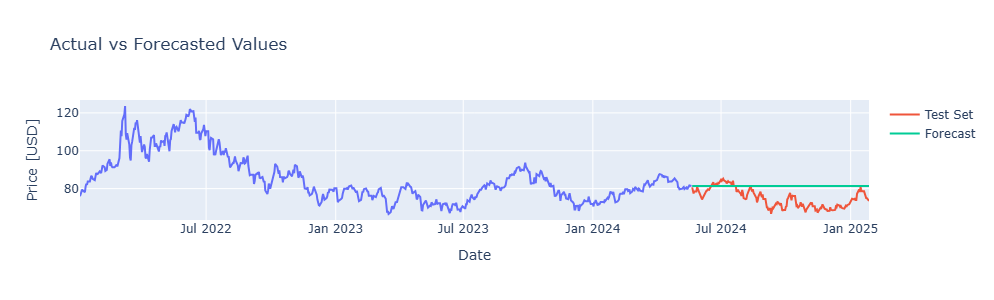

np.float64(23380.78080733584)

In [294]:
model_evaluate_plot(df, order=(0, 1, 1))

**Hyperparameter Tuning**

In [295]:
model_fit.aic

np.float64(23706.270230392078)

In [296]:
# Define the p, d and q parameters to take any value between 0 and 1
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

In [297]:
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

mean squared error: 156.0959192997767
root mean squared error: 12.493835251826267
ARIMA(0, 0, 0)- AIC:59333.01141820781


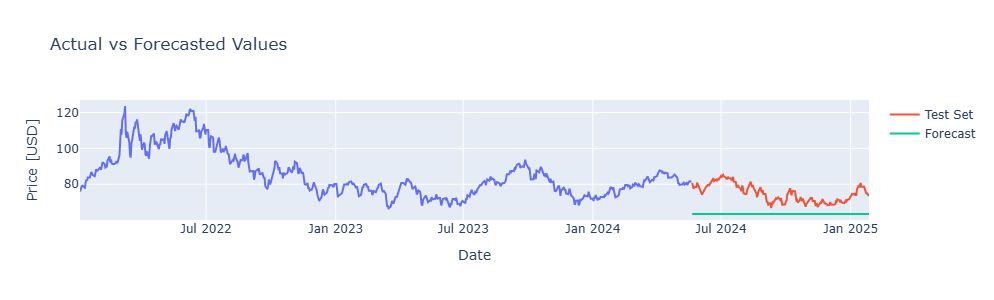

mean squared error: 156.1142271634211
root mean squared error: 12.494567906231136
ARIMA(0, 0, 1)- AIC:51065.13892667131


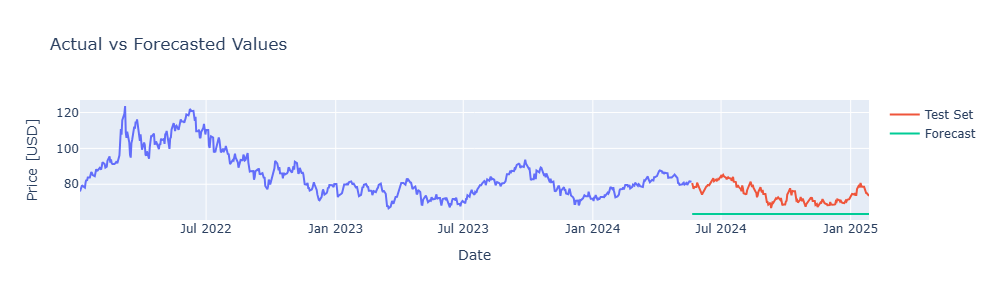

mean squared error: 66.60056888888889
root mean squared error: 8.160917159785956
ARIMA(0, 1, 0)- AIC:23385.17852631086


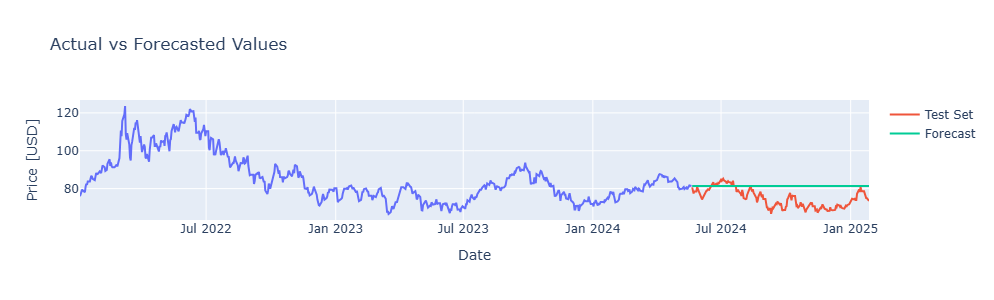

mean squared error: 66.70428809110577
root mean squared error: 8.167269316675297
ARIMA(0, 1, 1)- AIC:23380.78080733584


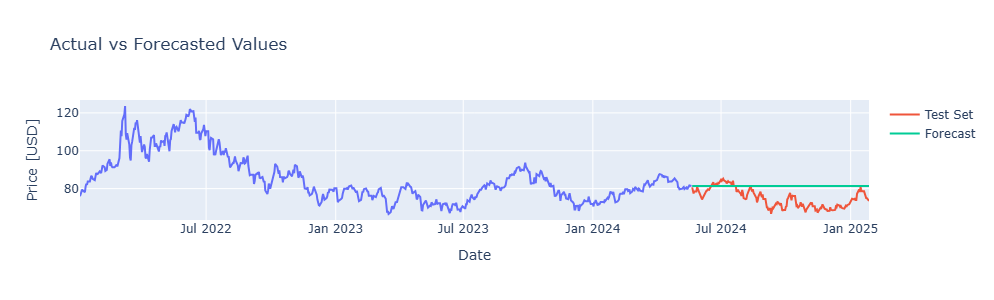

mean squared error: 31.05283064430681
root mean squared error: 5.572506675124473
ARIMA(1, 0, 0)- AIC:23393.297741197057


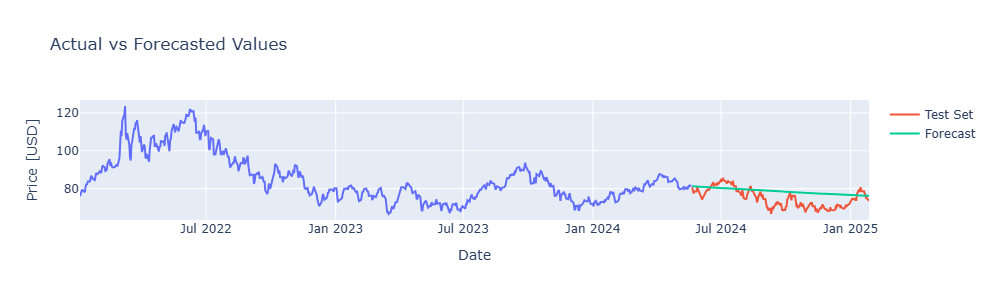

mean squared error: 32.292827523644256
root mean squared error: 5.682677847955509
ARIMA(1, 0, 1)- AIC:23389.277113912256


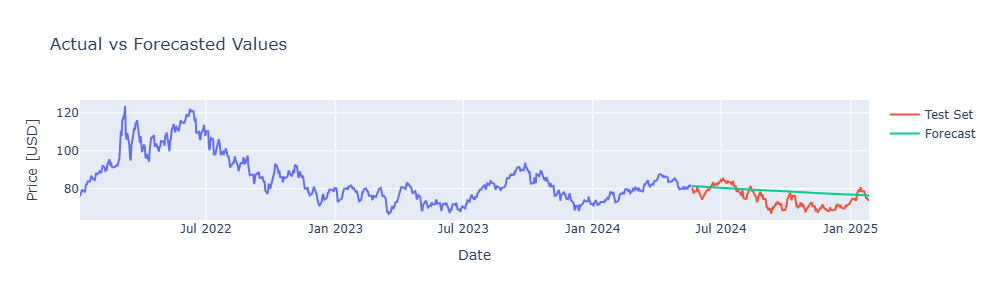

mean squared error: 66.7047930583612
root mean squared error: 8.167300230698098
ARIMA(1, 1, 0)- AIC:23381.223591626036


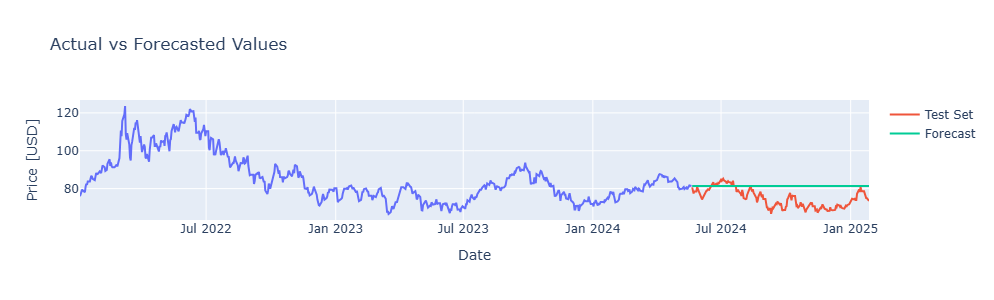

mean squared error: 66.27656708047896
root mean squared error: 8.141042137249933
ARIMA(1, 1, 1)- AIC:23379.26313213061


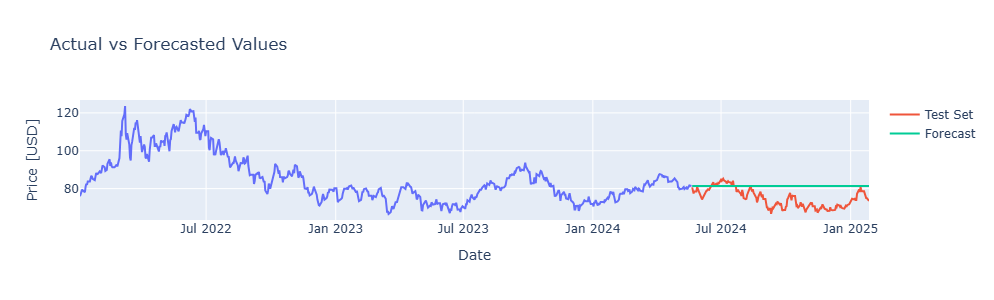

In [298]:
# Train and Evaluate using the grid search
for param in pdq:
    try:
        model_evaluate_plot(df, order=param)
        
    except:
        continue

`The model is struggling to capture the variability in the data which is due to external shocks in the data ( financial crises or pandemics). We would try  combinations of (p, d, q) with rolling cross validation to improve the ARIMA model to see if we would get a better result. Subsequently, we would try other models.`

In [305]:
# Create a helper function for rolling cross validation
def rolling_forecast_cv(data, order, test_size):
    history = list(data.iloc[:-test_size])
    test = data.iloc[-test_size:]
    predictions = []

    for t in range(len(test)):
        model = ARIMA(history, order=order)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        history.append(test[t])
    
    mse = mean_squared_error(test, predictions)
    
    print(f'Mean Squared Error: {mse:.3f}')
    
    
    return predictions, mse 

    




In [306]:
rolling_forecast_cv(df['value'], order=(0, 1, 1), test_size=30)

Mean Squared Error: 1.435


([np.float64(71.04558326125819),
  np.float64(70.33451471087551),
  np.float64(70.7844757051668),
  np.float64(70.12284304240374),
  np.float64(69.72376947798847),
  np.float64(69.50746193269353),
  np.float64(70.82453227281027),
  np.float64(70.86848313773541),
  np.float64(70.39630007720984),
  np.float64(71.25048559154996),
  np.float64(71.71399960028043),
  np.float64(72.41579304691113),
  np.float64(72.43919291789665),
  np.float64(73.74496743222538),
  np.float64(74.6102425643674),
  np.float64(74.3199889426711),
  np.float64(74.96769916669697),
  np.float64(74.02258599823507),
  np.float64(73.99108595877371),
  np.float64(77.16067095396116),
  np.float64(79.49107483936955),
  np.float64(78.24260371599495),
  np.float64(80.64736153989031),
  np.float64(79.39337981815564),
  np.float64(78.58781482463223),
  np.float64(78.56092834454225),
  np.float64(76.84909684545059),
  np.float64(76.14425825458402),
  np.float64(75.06701060499539),
  np.float64(74.9732213380544)],
 1.4350881366

In [307]:
# Let us change our prediction horizon to 6-months (180 days)
# Model order
results_params = {}
results_mse = {}
for param in pdq:
    try:
        forecast, mse = rolling_forecast_cv(df['value'], order=param, test_size=30)
        print('ARIMA{} - MSE:{}'.format(param, mse))
        results_params[param] = forecast
        results_mse[param] = mse
    except:
        continue



Mean Squared Error: 119.923
ARIMA(0, 0, 0) - MSE:119.92322634665692
Mean Squared Error: 32.455
ARIMA(0, 0, 1) - MSE:32.45483543601678
Mean Squared Error: 1.432
ARIMA(0, 1, 0) - MSE:1.431813333333333
Mean Squared Error: 1.435
ARIMA(0, 1, 1) - MSE:1.4350881366993675
Mean Squared Error: 1.432
ARIMA(1, 0, 0) - MSE:1.4323014376238374
Mean Squared Error: 1.436
ARIMA(1, 0, 1) - MSE:1.4356055720256815
Mean Squared Error: 1.435
ARIMA(1, 1, 0) - MSE:1.434551592867444
Mean Squared Error: 1.447
ARIMA(1, 1, 1) - MSE:1.447398286137993


In [202]:
# Convert the dictionary to a pandas DataFrame
df_mse = pd.DataFrame(list(results_mse.items()), columns=['ARIMA_Order', 'MSE'])

# Sort the DataFrame by MSE
df_mse = df_mse.sort_values(by='MSE')

df_mse

Empty DataFrame
Columns: [ARIMA_Order, MSE]
Index: []

The best ARIMA model from the hyperparameter tuning is ARIMA(0, 1, 0). We will build a final model with this and plot the result. We expect the model not to perform well from previous experiment without cross-validation, thus the need to explore more actions which includes:
* Consider an ARCH/GARCH model to account for volatility.
* Try a log transformation to stabilize variance.
* Use a more complex model that can handle external shocks or exogenous parameters e.g Prophet

In [203]:
# Build a final model (no cross validation)
model_evaluate_plot(df, 30, order=(0,1,0))

mean squared error: 20.396226666666664
root mean squared error: 4.516218181915779
ARIMA(0, 1, 0)- AIC:23936.043733676404


np.float64(23936.043733676404)

>
> Using order (0, 1, 0) is too simple - just a random walk model that means the best orediction for tomorrow is simply today's value. Thus the forecast is the previuos day value starting from the lag-1 training data endpoint. We can confirm if same state exist for the rolling cross validation.

In [204]:
# Build a final model (with cross validation)
forecast, test, mse = rolling_forecast_cv(df['value'], order=(0,1,0), test_size=30)

Mean Squared Error: 1.432


In [205]:
# Plot the actual vs forecasted values
test_size=30
train_df , test_df = df.iloc[:-test_size], df.iloc[-test_size:]

fig = px.line(train_df, x=train_df.loc['2022':].index,  y=train_df.loc['2022':]['value'], 
              title='Actual vs Forecasted Values',
              labels={'value':"Price"},
              width=700,  
              height=500) 
fig.add_scatter(x=test_df.index, y=test_df['value'], mode='lines+markers', name='Test Set')
fig.add_scatter(x=test_df.index, y=forecast, mode='lines', name='Forecast')
fig.update_layout(xaxis_title='Date',
                 yaxis_title='Price [USD]')

fig.show()

> There is the same random walk model issue existing. We will use values between 0 and 2 for the hyperparameter tuning

In [206]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

In [207]:
# Check the parameter grid 
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2)]

In [208]:
# Remove parameters with no differencing, 2nd order differencing and random walk models from grid after visual inspection

# Indices of elements to remove
indices_to_remove = [0, 1, 2, 3, 6, 7, 8, 9, 10, 11, 15, 16, 17, 18, 19, 20, 24, 25, 26]

# Create a new list excluding elements at the specified indices
pdq = [element for i, element in enumerate(pdq) if i not in indices_to_remove]

In [209]:
# Confirm the removal of these
pdq

[(0, 1, 1),
 (0, 1, 2),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2)]

In [210]:
# Train and Evaluate using the grid search with cross validation
for param in pdq:
    try:
        model_evaluate_plot(df, order=param)
        
    except:
        continue

mean squared error: 66.70428809110577
root mean squared error: 8.167269316675297
ARIMA(0, 1, 1)- AIC:23380.78080733584


mean squared error: 66.4351781414754
root mean squared error: 8.15077776297915
ARIMA(0, 1, 2)- AIC:23375.986124927436


mean squared error: 66.7047930583612
root mean squared error: 8.167300230698098
ARIMA(1, 1, 0)- AIC:23381.223591626036


mean squared error: 66.27656708047896
root mean squared error: 8.141042137249933
ARIMA(1, 1, 1)- AIC:23379.26313213061


mean squared error: 66.734641931173
root mean squared error: 8.169127366565721
ARIMA(1, 1, 2)- AIC:23384.250950507983


mean squared error: 66.47205127564196
root mean squared error: 8.153039388819483
ARIMA(2, 1, 0)- AIC:23375.250956974818


mean squared error: 66.49582960396498
root mean squared error: 8.154497507753925
ARIMA(2, 1, 1)- AIC:23377.160862814075


mean squared error: 66.8606086237231
root mean squared error: 8.176833655133452
ARIMA(2, 1, 2)- AIC:23363.687977310365


> The best parameter seems to be the (2, 1, 2). We will use this for the rolling cross validation to check performance even though it is getting glaring we need to handle the variablity in residual issue (external shocks?).

In [211]:
# Build a final model (with cross validation)
forecast, test, mse = rolling_forecast_cv(df['value'], order=(2,1,2), test_size=30)

Mean Squared Error: 1.442


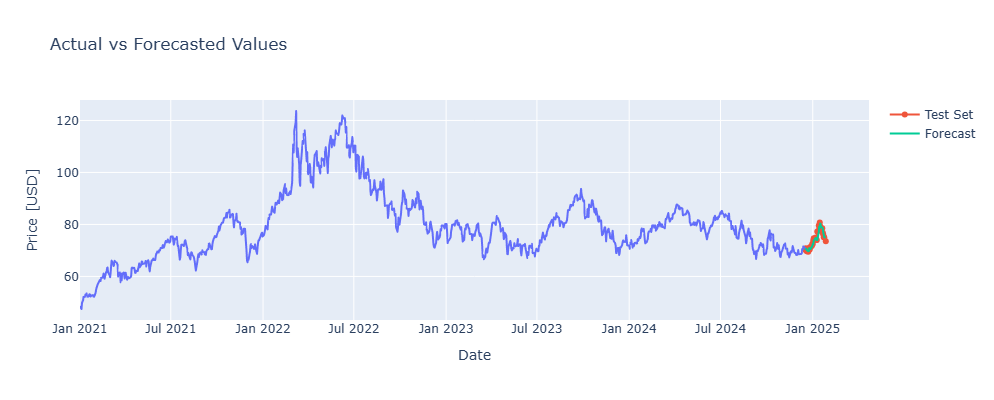

In [308]:
# Plot the actual vs forecasted values
test_size=30
train_df , test_df = df.iloc[:-test_size], df.iloc[-test_size:]


fig = px.line(train_df, x=train_df.loc['2021':].index,  y=train_df.loc['2021':]['value'], 
              title='Actual vs Forecasted Values',
              labels={'value':"Price"},
              width=700,  
              height=400) 
fig.add_scatter(x=test_df.index, y=test, mode='lines+markers', name='Test Set')
fig.add_scatter(x=test_df.index, y=forecast, mode='lines', name='Forecast')
fig.update_layout(xaxis_title='Date',
                 yaxis_title='Price [USD]')

fig.show()

In [213]:
forecast

[np.float64(71.00430027416006),
 np.float64(70.33614345026449),
 np.float64(70.82505610995187),
 np.float64(70.09426571676163),
 np.float64(69.71572927575264),
 np.float64(69.52010339953735),
 np.float64(70.83136412091379),
 np.float64(70.81866883674425),
 np.float64(70.41718671833556),
 np.float64(71.30969697329871),
 np.float64(71.67263233048216),
 np.float64(72.37569301411993),
 np.float64(72.46001069560786),
 np.float64(73.80298539220279),
 np.float64(74.5718750570138),
 np.float64(74.28060982082447),
 np.float64(75.02545151646568),
 np.float64(74.03534563430634),
 np.float64(73.9903598051059),
 np.float64(77.1337650025806),
 np.float64(79.4087552407818),
 np.float64(78.27329465909546),
 np.float64(80.82231488168435),
 np.float64(79.29488812323306),
 np.float64(78.53098050563267),
 np.float64(78.6154811038621),
 np.float64(76.87630642153218),
 np.float64(76.14786951004716),
 np.float64(75.01329141505796),
 np.float64(74.96974520338081)]

In [214]:
test

date
2024-12-17    70.31
2024-12-18    70.80
2024-12-19    70.10
2024-12-20    69.71
2024-12-23    69.50
2024-12-24    70.87
2024-12-25    70.87
2024-12-26    70.38
2024-12-27    71.28
2024-12-30    71.73
2024-12-31    72.44
2025-01-01    72.44
2025-01-02    73.79
2025-01-03    74.64
2025-01-06    74.31
2025-01-07    74.99
2025-01-08    73.99
2025-01-09    73.99
2025-01-10    77.27
2025-01-13    79.57
2025-01-14    78.20
2025-01-15    80.73
2025-01-16    79.35
2025-01-17    78.56
2025-01-20    78.56
2025-01-21    76.79
2025-01-22    76.12
2025-01-23    75.03
2025-01-24    74.97
2025-01-27    73.51
Name: value, dtype: float64

> Finally let us train the model with all the dataset using the order (2, 1, 2)

In [311]:
# Instantiate, train and fit the data on the model
model = ARIMA(df['value'], order = (2, 1, 2))

In [312]:
# Fit the model
model_fit = model.fit()

In [317]:
# Forecast for the next 90 days
forecast = model_fit.forecast(90)

In [319]:
forecast

6540    73.569171
6541    73.607745
6542    73.564809
6543    73.527568
6544    73.557465
          ...    
6625    73.563457
6626    73.563449
6627    73.563442
6628    73.563448
6629    73.563454
Name: predicted_mean, Length: 90, dtype: float64

In [335]:
last_date = df.index[-1]

# Calculate the next date
next_date = last_date + pd.DateOffset(1)

date_range = pd.date_range(start=next_date, periods=90, freq='D')

In [336]:
date_range

DatetimeIndex(['2025-01-28', '2025-01-29', '2025-01-30', '2025-01-31',
               '2025-02-01', '2025-02-02', '2025-02-03', '2025-02-04',
               '2025-02-05', '2025-02-06', '2025-02-07', '2025-02-08',
               '2025-02-09', '2025-02-10', '2025-02-11', '2025-02-12',
               '2025-02-13', '2025-02-14', '2025-02-15', '2025-02-16',
               '2025-02-17', '2025-02-18', '2025-02-19', '2025-02-20',
               '2025-02-21', '2025-02-22', '2025-02-23', '2025-02-24',
               '2025-02-25', '2025-02-26', '2025-02-27', '2025-02-28',
               '2025-03-01', '2025-03-02', '2025-03-03', '2025-03-04',
               '2025-03-05', '2025-03-06', '2025-03-07', '2025-03-08',
               '2025-03-09', '2025-03-10', '2025-03-11', '2025-03-12',
               '2025-03-13', '2025-03-14', '2025-03-15', '2025-03-16',
               '2025-03-17', '2025-03-18', '2025-03-19', '2025-03-20',
               '2025-03-21', '2025-03-22', '2025-03-23', '2025-03-24',
      

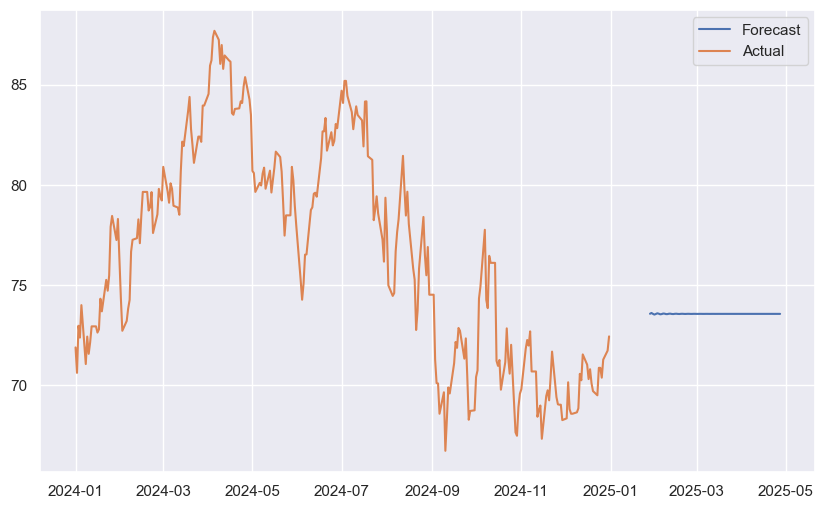

In [340]:
# Plot the predicted values along with the actual data 

plt.figure(figsize=(10, 6))
plt.plot(date_range,forecast, label='Forecast')
plt.plot(df['value']['2024'], label="Actual")
plt.legend()
plt.show()

In [ ]:
We wo

**Let's use try a SARIMAX model**

In [ ]:
# Fit the model on the training dataset
model = ARIMA(train_df['value'], order=(2, 1, 2), seasonal_order=(2, 1, 2, 365))
model_fit = model.fit()

In [ ]:
# Forecast for the test set period
start = len(train_df)
end = len(train_df) + len(test_df) - 1
forecast = model_fit.predict(start=start, end=end)
print(forecast)

In [158]:
# Calculate accuracy metrics

mse = mean_squared_error(test_df['value'], forecast)
rmse = root_mean_squared_error(test_df['value'], forecast)

print('mean squared error:', mse)
print('root mean squared error:', rmse)

ValueError: Found input variables with inconsistent numbers of samples: [180, 1090]

We do not have a different outcome, thus showing the issue is not seasonality but the random variation from external shock. We will use the Prophet and GARCH model which should be better suited to this type of data.

### Generalized Autoregressive Conditional Heteroskedasticity (GARCH) Modelling

In [ ]:
from arch import arch_model

In [ ]:
model = arch_model(df1['diff'].dropna(), vol='Garch', p=3, q=2)
model_fit = model.fit()

In [ ]:
print(model_fit.summary())

In [ ]:
model_fit.plot()
plt.show()

In [ ]:

forecast = model_fit.forecast(horizon=30)

# Extract forecasted variance for the 10-day horizon
forecast_variance = forecast.variance.iloc[-1]

# Plot the forecasted variance (volatility)
plt.figure(figsize=(10, 6))
plt.plot(forecast_variance.index, forecast_variance.values, marker='o')
plt.title("30-Day Volatility Forecast")
plt.xlabel("Days Ahead")
plt.ylabel("Forecasted Variance")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()



In [ ]:

forecast = model_fit.forecast(start=0, horizon=len(test_df))

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Extract forecasted volatility from the forecast object
forecasted_volatility = np.sqrt(forecast.variance.iloc[-len(test_df):].values)

# Calculate actual volatility (realized volatility) as the rolling standard deviation
actual_volatility = test_df['diff'].rolling(window=10).std().dropna().values  # Using a window of 10 for rolling volatility

# Trim the forecasted volatility to match the length of actual volatility
forecasted_volatility = forecasted_volatility[-len(actual_volatility):,1]

# Ensure both forecasted and actual volatility are arrays and have the same length
forecasted_volatility = np.array(forecasted_volatility)
actual_volatility = np.array(actual_volatility)

# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(actual_volatility, forecasted_volatility))

print(f'RMSE: {rmse}')


In [ ]:
actual_volatility.shape

In [ ]:
forecasted_volatility.shape

# PROPHET MODELLING

Next we would use Facebook Prophet model to see if we can take care of the complexity of external factors. As expected crude oil prices is affected by global economic and social issues which are not predictable without using some exogenous data.

In [ ]:
# Instantiate the prophet model
model_fbp = Prophet()

In [ ]:
# verify the training data we have
train_df.tail()

In [ ]:
# lets update a training DF for Prophet 
train_df.drop('diff', axis=1, inplace=True)

In [ ]:
# lets rename the DF as required in `fbprophet`
train_df_fbp = train_df.copy()
train_df_fbp.rename(columns={'value':'y'}, inplace=True)
train_df_fbp.index.name = 'ds'

In [ ]:
# Confirm the training data column headings is ds and y
train_df_fbp.reset_index(inplace=True)

In [ ]:
# Fit the training data to the model
model_fbp.fit(train_df_fbp)

In [ ]:
# Create options for period(s) to forecast

forecast_period = interval[2]
period_dict = {'daily': 1, 'monthly': 30, 'yearly': 365}
n_select = 2

In [ ]:
# Create a future DataFrame for forecasting
future = model_fbp.make_future_dataframe(periods=period_dict[forecast_period] * n_select)


In [ ]:
# Make a forecast 
forecast = model_fbp.predict(future)

In [ ]:
# Check the tail of the forecast to confirm period forecasted 
forecast.tail()

In [ ]:
# Plot the graph for the forecast
fig = plot_plotly(model_fbp, forecast)
fig.layout.update(title = f'{forecast_period}'.title() + " Forecast for " + f'{commodities[0]} ' + "(" +  f'{n_select}' + "-" +
                  f'{forecast_period}'[:-2] + ")",
                  xaxis_title= 'Date', yaxis_title='Price')
fig.show()


The prophet algorithm is strong to handle the complexity of the dataset. We will thus use this to handle the remaining commodities.

In [ ]:
# CRUDE OIL (BRENT)

In [ ]:
# Download the brent data from Alpha Vantage
brent_data = cd.get_brent(interval[0])

In [ ]:
# Confirm the data type of downloaded data
type(brent_data)

In [ ]:
# Explore the downloaded tuple
brent_data

In [ ]:
# Extract the DataFrame from the tuple adn explore the top 5 rows
brent_df = brent_data[0]
brent_df.head()

In [ ]:
# Explore the general information on the DataFrame
brent_df.info()

There is no missing values, however there is need to clean the data for data type. The date should be datetime and value should be float.

In [ ]:
# Convert date to datetime
brent_df['date'] = pd.to_datetime(brent_df['date'])

# Convert value to float
brent_df['value'] = brent_df['value'].astype('float')

In [ ]:
# let's check for values in the value column
pd.set_option('display.max_rows', None)
brent_df['value'].value_counts()

We will need to remove the `.` just like for `WTI` dataset

In [ ]:
# Reset the display
pd.reset_option('all')
# Explore the instances of . as values further
len(brent_df[brent_df['value'] == '.'])

In [ ]:
# Replace . with nan
brent_df['value'] = brent_df['value'].replace('.', np.nan)

# Impute missing values with NaN
brent_df.bfill(inplace=True)

# Convert value column to float
brent_df['value'] = brent_df['value'].astype('float')

In [ ]:
brent_df.info()

This shows that we have the same issues with the Alpha Vantage datasets, thus, we will define the same pipeline for loading and transforming the data

In [ ]:
# Convert the dataset to a time series
brent_df.set_index('date', inplace=True)

In [ ]:
# Plot the distribution of the data
sns.displot(brent_df['value'], kind='hist', kde=True)
plt.ylabel('Frequency')
plt.xlabel('Price')
plt.title('Distribution of Crude Oil Prices (Brent)');

Just like for WTI, the data is skewed to the right showing few periods of very high crude oil prices within the period. We will plot the trend to see how this looks like

In [ ]:
# Plot the trend line for the whole period
brent_df.plot()
plt.title('Price Trend for Crude Oil (Brent)')
plt.xlabel('Date')
plt.ylabel("price")
plt.show();

In [ ]:
# We will compare this with crude oil (WTI) prices

fig , ax = plt.subplots(figsize=(8, 5))
plt.plot(brent_df, label='Brent')
plt.plot(df, label='WTI')
plt.title('Price Trend for Crude Oil (Brent)')
plt.xlabel('Date')
plt.ylabel("price")
plt.legend()
plt.show();

Both types of crude oil follow similar trend such we can use the same model to predict i.e. Prophet

In [ ]:
# Split the data into training and test datasets
train_size = int(len(brent_df) * 0.8)

train_df_brent = brent_df.iloc[:train_size]
test_df_brent = brent_df.iloc[train_size:]

print('The shape of the train data is:', train_df_brent.shape)
print('The shape of the test data is:', test_df_brent.shape)

In [ ]:
# Create a function to prepare data for training with prophet
def prep_train_data_prophet(df):
    # lets rename the DF as required in `fbprophet`
    df_fbp = df.copy()
    df_fbp.reset_index(inplace=True)
    df_fbp.rename(columns={'value':'y', 'date': 'ds'}, inplace=True)
    df_fbp = df_fbp[['ds', 'y']]
    df_fbp.sort_values('ds',inplace=True)
    train_size = int(len(df_fbp) * 0.8)

    train_df_brent = df_fbp.iloc[:train_size]
    test_df_brent = df_fbp.iloc[train_size:]

    
    return train_df_brent , test_df_brent

In [ ]:
train_df_brent, test_df_brent = prep_train_data_prophet(brent_df)

In [ ]:
train_df_brent

In [ ]:
test_df_brent

In [ ]:
print('The shape of the train data is:', train_df_brent.shape)
print('The shape of the test data is:', test_df_brent.shape)

In [ ]:
model_fbp = Prophet()
model_fbp.fit(train_df_brent)

In [ ]:
# Forecast for the test set period

future = model_fbp.make_future_dataframe(periods=len(test_df_brent))
forecast = model_fbp.predict(future)

In [ ]:
forecast

In [ ]:
forecast[-len(test_df_brent['y']):].yhat

In [ ]:
# Calculate accuracy metrics

mse = mean_squared_error(test_df_brent['y'], forecast[-len(test_df_brent['y']):].yhat)
rmse = root_mean_squared_error(test_df_brent['y'], forecast[-len(test_df_brent['y']):].yhat)

print('mean squared error:', mse)
print('root mean squared error:', rmse)

In [ ]:
# Plot the actual vs forecasted values
fig = px.line(train_df_brent, x=train_df_brent['ds'],  y=train_df_brent['y'], 
              title='Actual vs Forecasted Values',
              labels={'value':"Price"},
              width=800,  
              height=500) 
fig.add_scatter(x=test_df_brent['ds'], y=test_df_brent['y'], mode='lines', name='Test Set')
fig.add_scatter(x=test_df_brent['ds'], y=forecast[-len(test_df_brent['y']):].yhat, mode='lines', name='Forecast')

fig.show()

In [ ]:
# Plot the graph for the forecast
fig = plot_plotly(model_fbp, forecast)
# fig.layout.update(title = f'{forecast_period}'.title() + " Forecast for " + f'{commodities[0]} ' + "(" +  f'{n_select}' + "-" +
#                   f'{forecast_period}'[:-2] + ")",
#                   xaxis_title= 'Date', yaxis_title='Price')
fig.show()

The model is predicting negative values which is not desirable for commodity prices. This proves that the model in the current state is not good enough. We would thus explore carrying out `Hyperparameter tuning` and `Cross-validation`

### Fit and Evaluate Model
#### Lets create a function to fit instantiate, fit and evaluate the a model 

In [ ]:
def fit_evaluate(data, param_grid):
    model = Prophet()
